# X Detection Pipeline v2

## Approach
1. **HSV-based Glare Detection & Removal**: Detect and inpaint glare regions
2. **Adaptive Thresholding**: Detect dark regions with morphological operations
3. **Dynamic Template Matching**: Find X patterns using blob-sized templates

## Key Features
- HSV colour space for accurate glare detection (bright + desaturated)
- Inpainting for non-distorting glare removal
- Morphological operations to connect nearby regions
- Dynamic template matching: template sized to each blob for accuracy

In [1]:
# Imports
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams['image.cmap'] = 'gray'

print(f"OpenCV version: {cv2.__version__}")
print("Libraries loaded successfully")


OpenCV version: 4.12.0
Libraries loaded successfully


In [2]:
# Configuration
VIDEO_PATH = "../../videos/example.mp4"

# Glare detection (HSV-based)
VALUE_THRESHOLD = 200        # Brightness threshold (0-255)
SATURATION_THRESHOLD = 50    # Saturation threshold (0-255)

# Morphological operations
MORPH_KERNEL_SIZE = 5        # Kernel size (must be odd)
MORPH_CLOSE_ITERATIONS = 2   # Fill gaps
MORPH_OPEN_ITERATIONS = 1    # Remove noise

# X detection (blob filtering)
MIN_BLOB_SIZE = 300          # Minimum blob area (pixels)
MAX_BLOB_SIZE = 8000         # Maximum blob area (pixels)

# Template matching
TEMPLATE_PADDING = 1.2       # Template size multiplier
LINE_THICKNESS_RATIO = 0.14  # Line thickness as ratio
MATCH_THRESHOLD = 0.4        # Minimum match score (0-1)

print("Configuration loaded")


Configuration loaded


In [3]:
# Load video metadata
cap = cv2.VideoCapture(VIDEO_PATH)
fps = cap.get(cv2.CAP_PROP_FPS)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
cap.release()

print(f"Video: {width}x{height}, {fps:.1f} fps, {total_frames} frames ({total_frames/fps:.1f} sec)")


Video: 1280x720, 30.0 fps, 31211 frames (1040.4 sec)


In [4]:
# Frame Selection
# Option 1: Specify frame indices
SELECTED_FRAMES = [0 + 30*i for i in range(20)]  # List specific frames, e.g., [0, 1000, 5000] or None for auto-sampling

# Option 2: Auto-sample N frames evenly
NUM_AUTO_SAMPLES = 5   # Used if SELECTED_FRAMES is None or empty

def get_frames(video_path, frame_indices=None, num_samples=5):
    """Load specific frames or auto-sample evenly distributed frames."""
    cap = cv2.VideoCapture(video_path)
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    if frame_indices is None or len(frame_indices) == 0:
        # Auto-sample
        frame_indices = np.linspace(0, total - 1, num_samples, dtype=int)
    
    frames = []
    for idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if ret:
            frames.append((idx, cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)))
    
    cap.release()
    return frames

# Load frames
samples = get_frames(VIDEO_PATH, SELECTED_FRAMES, NUM_AUTO_SAMPLES)
print(f"Loaded {len(samples)} frames: {[idx for idx, _ in samples]}")


Loaded 20 frames: [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360, 390, 420, 450, 480, 510, 540, 570]


In [5]:
# Processing Pipeline

def detect_and_remove_glare(frame):
    """Detect glare using HSV and remove via inpainting."""
    # Convert to HSV
    hsv = cv2.cvtColor(frame, cv2.COLOR_RGB2HSV)
    saturation = hsv[:, :, 1]
    value = hsv[:, :, 2]
    
    # Glare = bright (high V) AND desaturated (low S)
    glare_mask = ((value > VALUE_THRESHOLD) & (saturation < SATURATION_THRESHOLD)).astype(np.uint8)
    
    # Convert to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    
    # Inpaint glare regions
    kernel = np.ones((3, 3), np.uint8)
    dilated_glare = cv2.dilate(glare_mask, kernel, iterations=1)
    deglared = cv2.inpaint(gray, dilated_glare, inpaintRadius=3, flags=cv2.INPAINT_TELEA)
    
    return deglared, glare_mask

def create_adaptive_mask(deglared):
    """Apply adaptive thresholding with morphological operations."""
    # Adaptive threshold
    adaptive_mask = cv2.adaptiveThreshold(
        deglared, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV, blockSize=51, C=10
    )
    
    # Morphological operations
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (MORPH_KERNEL_SIZE, MORPH_KERNEL_SIZE))
    closed = cv2.morphologyEx(adaptive_mask, cv2.MORPH_CLOSE, kernel, iterations=MORPH_CLOSE_ITERATIONS)
    cleaned = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel, iterations=MORPH_OPEN_ITERATIONS)
    
    return cleaned

print("Processing functions defined")


Processing functions defined


In [ ]:
# X Detection - Dynamic Template Matching

def create_x_template(width, height, thickness):
    """Create X-shaped template with padding (can be rectangular)."""
    template = np.zeros((height, width), dtype=np.uint8)
    
    # Add padding so X doesn't touch edges
    padding_w = int(width * 0.1)   # 10% padding
    padding_h = int(height * 0.1)  # 10% padding
    
    # Draw X with padding
    cv2.line(template, 
             (padding_w, padding_h), 
             (width-1-padding_w, height-1-padding_h), 
             255, thickness)
    cv2.line(template, 
             (padding_w, height-1-padding_h), 
             (width-1-padding_w, padding_h), 
             255, thickness)
    return template

def detect_x(cleaned_mask, frame_shape):
    """
    Detect X using blob detection + dynamic template matching.
    
    Returns: (x_detected, confidence, details, all_candidates)
    """
    h, w = frame_shape[:2]
    
    # Find connected components (blobs)
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(
        cleaned_mask, connectivity=8
    )
    
    candidates = []
    
    for i in range(1, num_labels):  # Skip background
        area = stats[i, cv2.CC_STAT_AREA]
        
        # Filter by size
        if not (MIN_BLOB_SIZE <= area <= MAX_BLOB_SIZE):
            continue
        
        # Get blob bounding box
        bx = stats[i, cv2.CC_STAT_LEFT]
        by = stats[i, cv2.CC_STAT_TOP]
        bw = stats[i, cv2.CC_STAT_WIDTH]
        bh = stats[i, cv2.CC_STAT_HEIGHT]
        
        # Skip edge-touching blobs
        if bx <= 5 or by <= 5 or (bx + bw) >= (w - 5) or (by + bh) >= (h - 5):
            continue
        
        # Create template sized to blob (rectangular, matching blob aspect ratio)
        template_width = int(bw * TEMPLATE_PADDING)
        template_height = int(bh * TEMPLATE_PADDING)
        
        if template_width < 20 or template_height < 20 or template_width > w or template_height > h:
            continue
        
        # Line thickness based on average dimension
        avg_size = (template_width + template_height) // 2
        line_thickness = max(2, int(avg_size * LINE_THICKNESS_RATIO))
        template = create_x_template(template_width, template_height, line_thickness)
        
        # Extract region around blob
        pad_w = (template_width - bw) // 2
        pad_h = (template_height - bh) // 2
        rx1 = max(0, bx - pad_w)
        ry1 = max(0, by - pad_h)
        rx2 = min(w, bx + bw + pad_w)
        ry2 = min(h, by + bh + pad_h)
        
        blob_region = cleaned_mask[ry1:ry2, rx1:rx2]
        
        # Store blob region for visualisation
        blob_image = blob_region.copy()
        
        # Resize template if needed
        region_h, region_w = blob_region.shape
        if template.shape[1] != region_w or template.shape[0] != region_h:
            template = cv2.resize(template, (region_w, region_h))
        
        # Template matching with blur for robustness
        if blob_region.shape[0] >= template.shape[0] and blob_region.shape[1] >= template.shape[1]:
            # Apply Gaussian blur to both template and blob region
            template_blur = cv2.GaussianBlur(template, (5, 5), 1)
            blob_region_blur = cv2.GaussianBlur(blob_region, (5, 5), 1)
            
            # Match blurred versions
            result = cv2.matchTemplate(blob_region_blur, template_blur, cv2.TM_CCOEFF_NORMED)
            min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
            
            cx, cy = centroids[i]
            candidates.append({
                'area': area,
                'bbox': (bx, by, bw, bh),
                'centroid': (cx, cy),
                'match_score': max_val,
                'template_width': template_width,
                'template_height': template_height,
                'line_thickness': line_thickness,
                'blob_image': blob_image
            })
    
    if len(candidates) == 0:
        return False, 0.0, {'reason': 'no_valid_blobs', 'total_blobs': num_labels - 1}, []
    
    # Best match
    candidates.sort(key=lambda x: x['match_score'], reverse=True)
    best = candidates[0]
    
    x_detected = best['match_score'] >= MATCH_THRESHOLD
    
    details = {
        'match_score': best['match_score'],
        'template_width': best['template_width'],
        'template_height': best['template_height'],
        'line_thickness': best['line_thickness'],
        'area': best['area'],
        'bbox': best['bbox'],
        'centroid': best['centroid'],
        'num_candidates': len(candidates)
    }
    
    if not x_detected:
        details['reason'] = 'below_threshold'
    
    return x_detected, best['match_score'], details, candidates

print("X detection function defined")

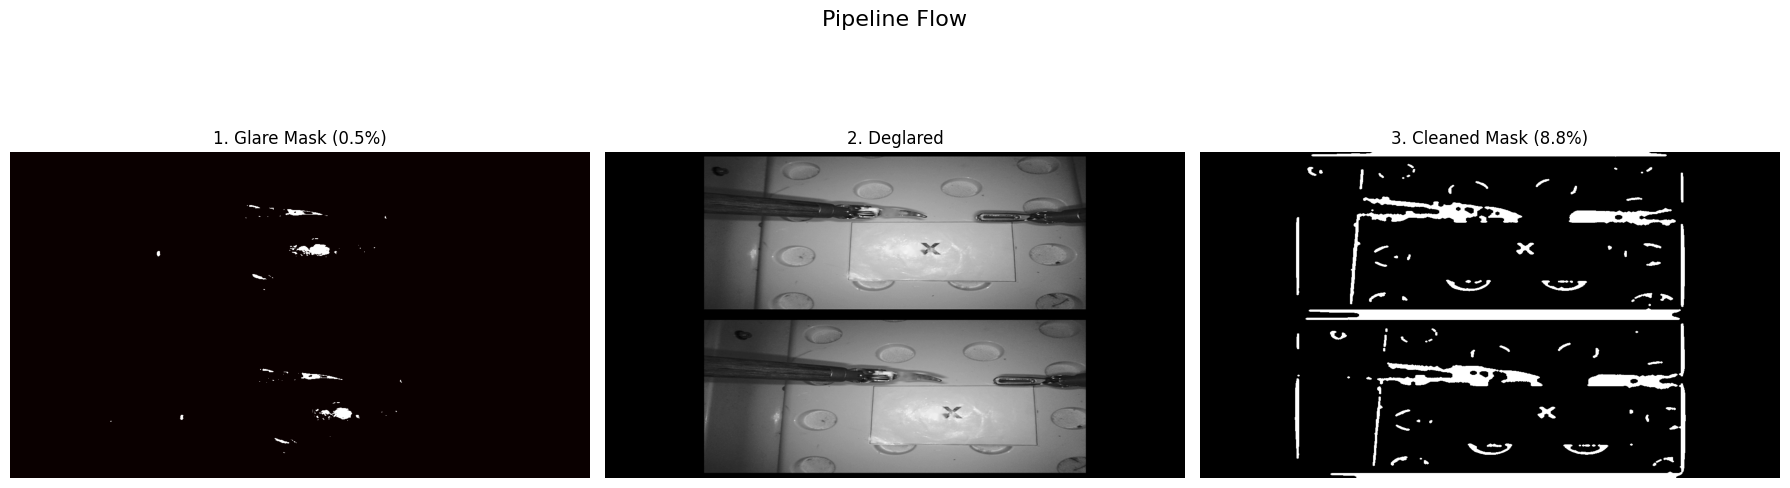


PIPELINE FLOW (Frame 0)



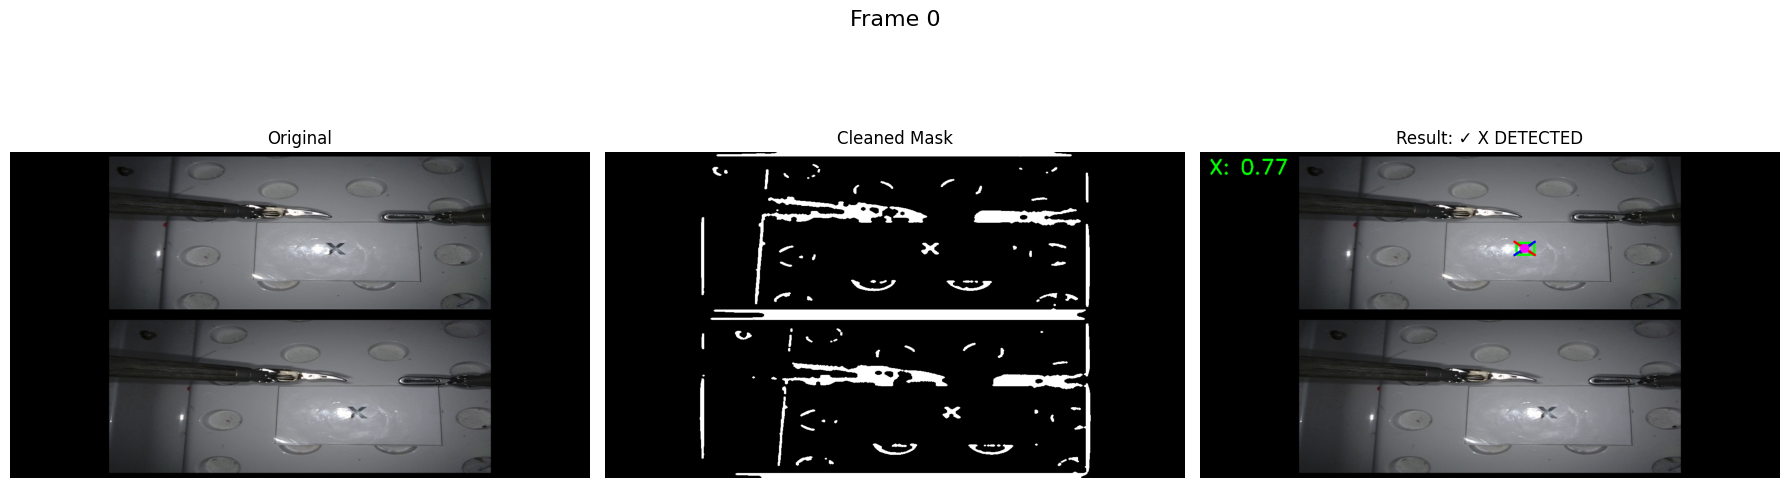

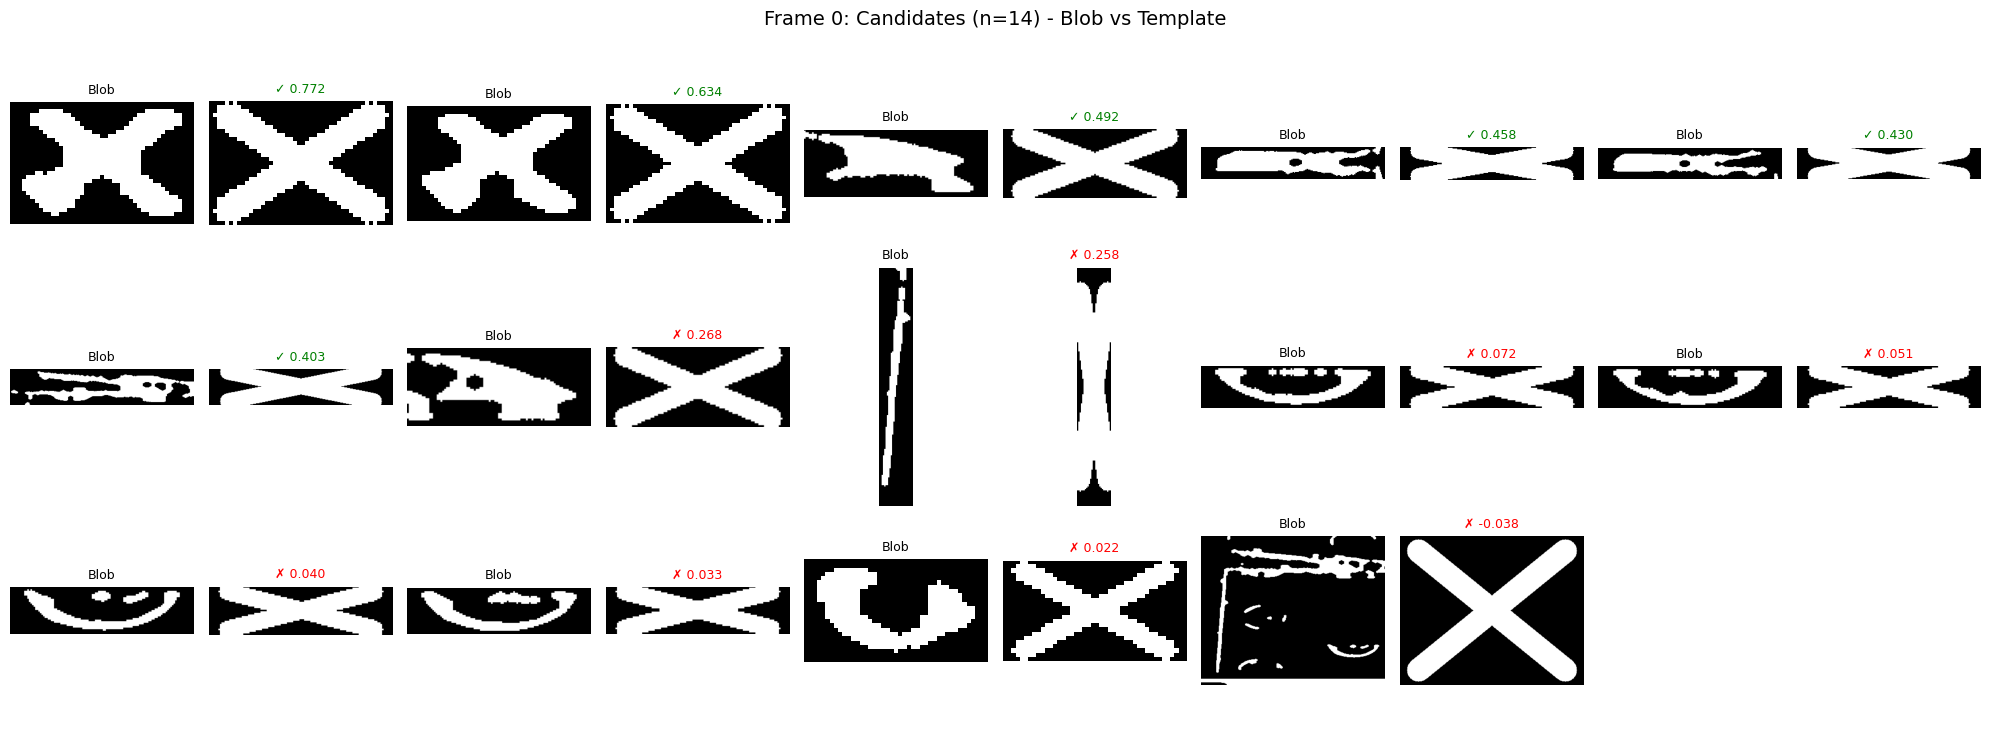


Frame 0:
  X Detected: True
  Match Score: 0.772 (threshold: 0.4)
  Template: 46x31px (thickness: 5px)
  Blob area: 568 pixels
  Total candidates: 14
  Score range: [-0.038, 0.772]



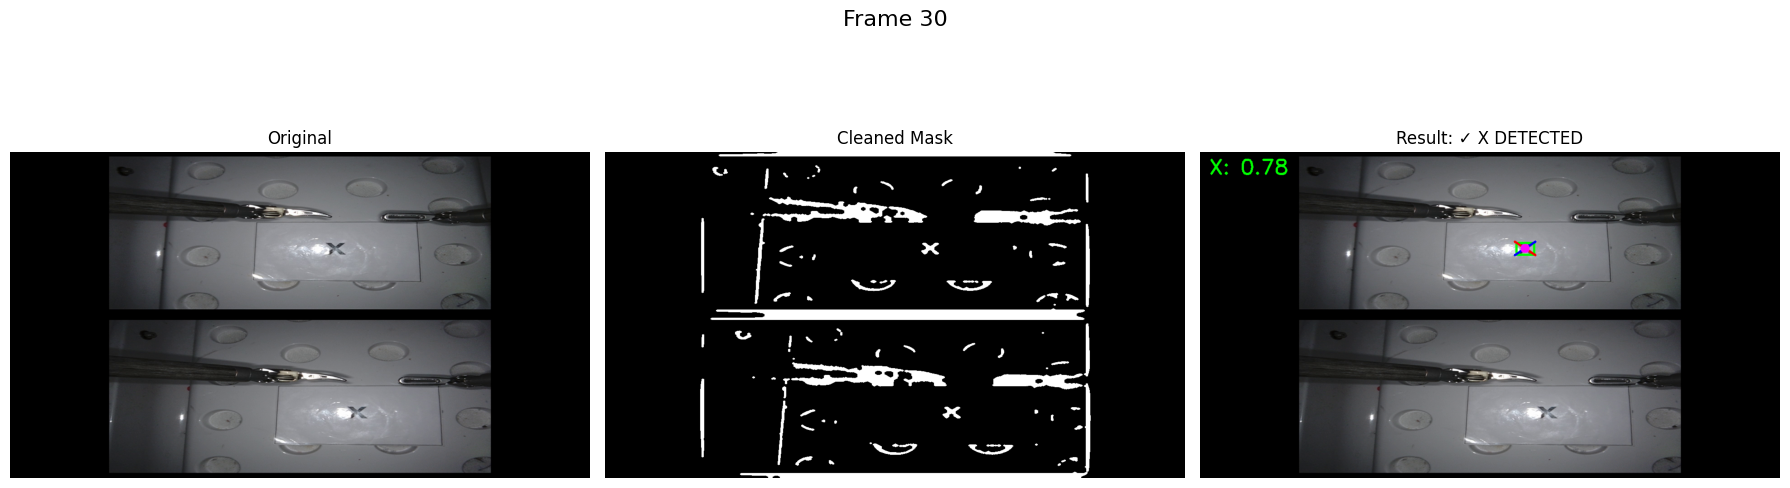

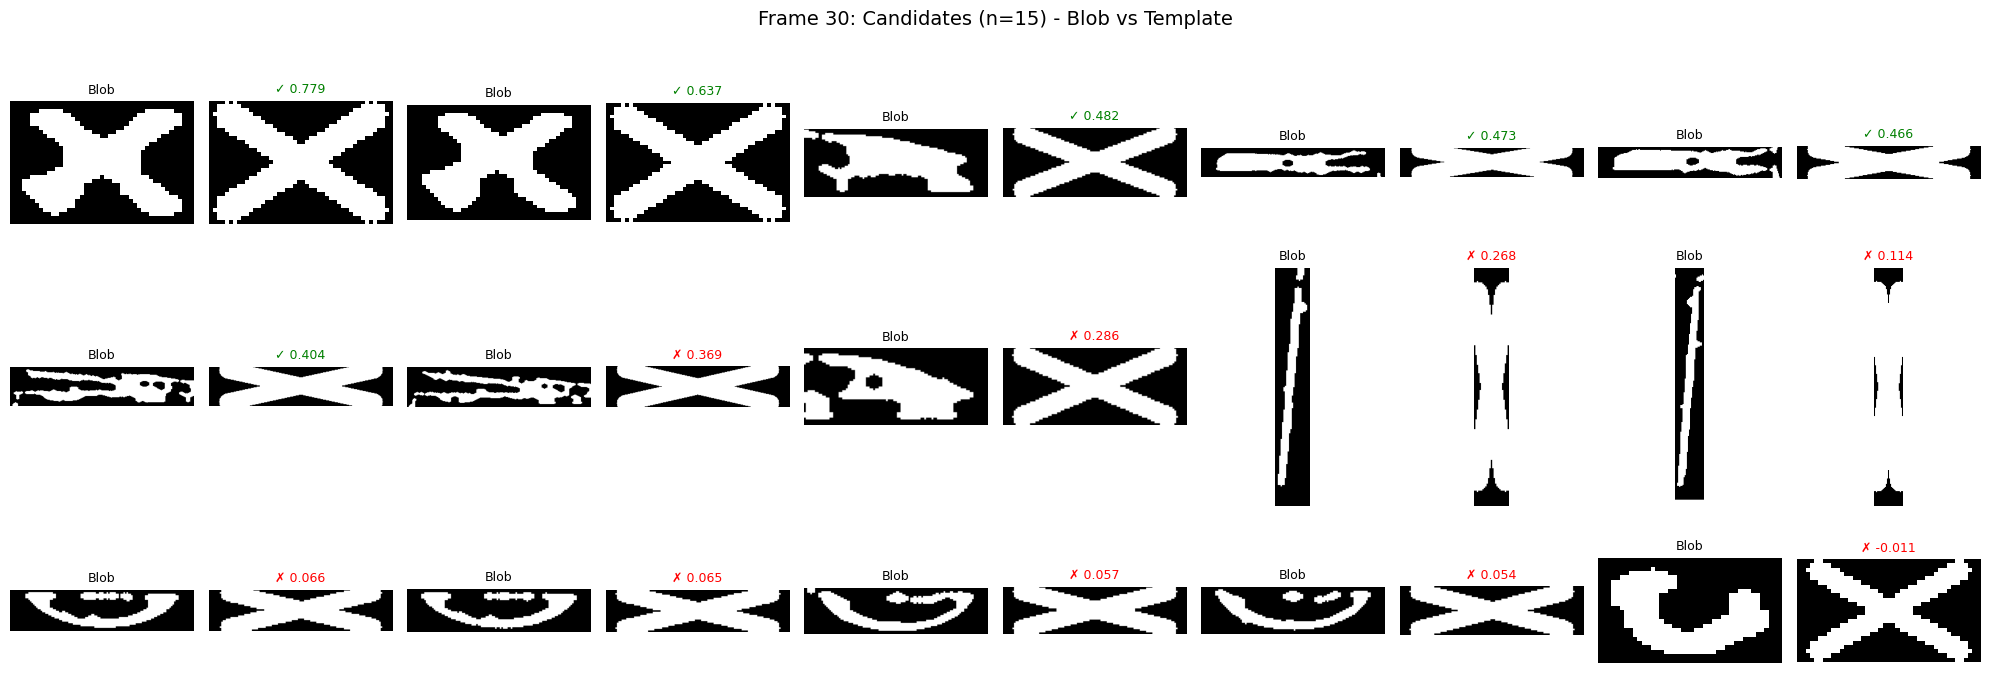


Frame 30:
  X Detected: True
  Match Score: 0.779 (threshold: 0.4)
  Template: 46x31px (thickness: 5px)
  Blob area: 565 pixels
  Total candidates: 15
  Score range: [-0.011, 0.779]



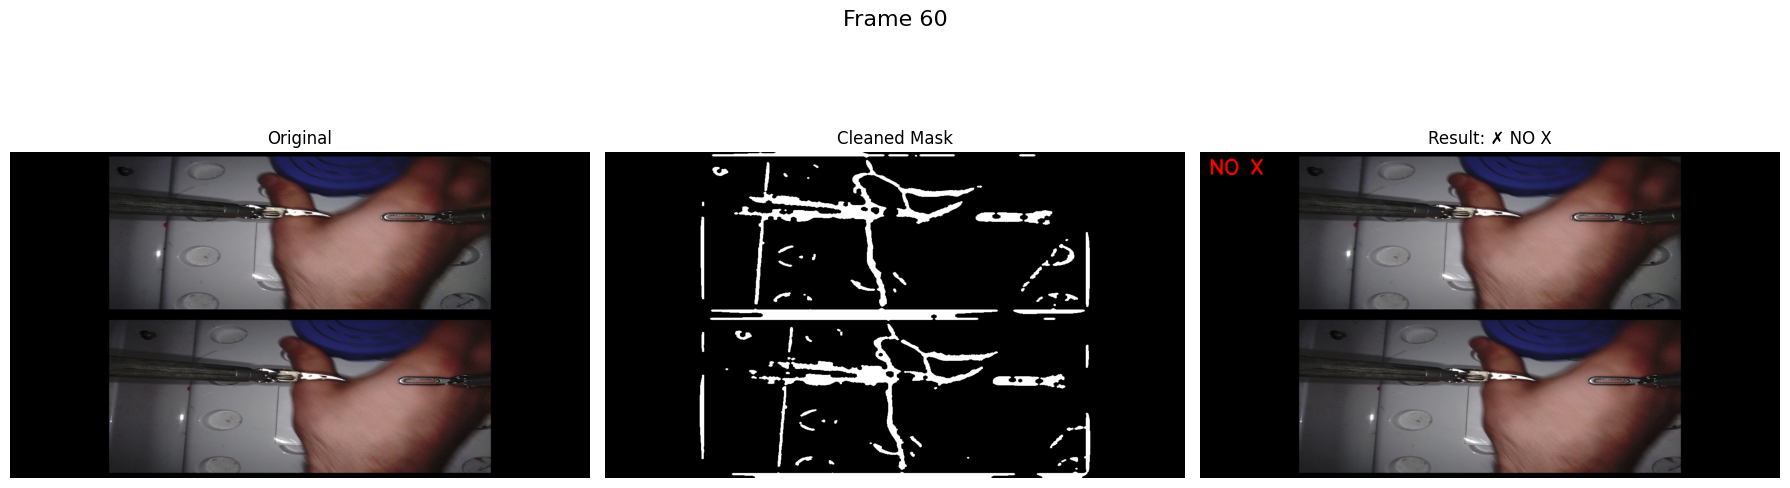

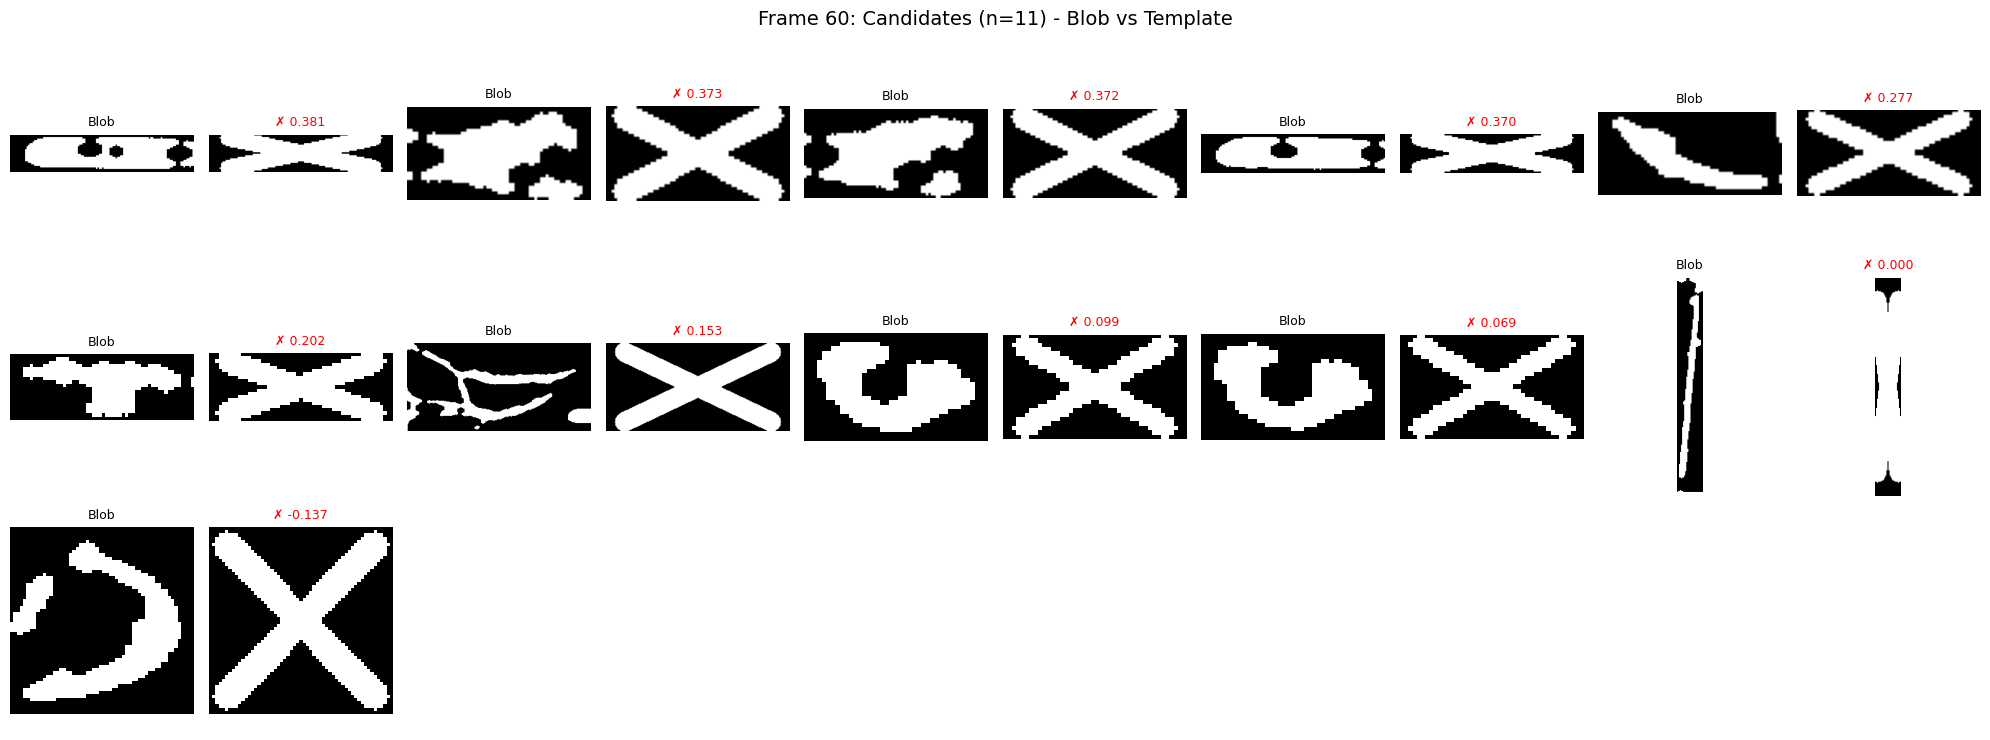


Frame 60:
  X Detected: False
  Match Score: 0.381 (threshold: 0.4)
  Total candidates: 11
  Score range: [-0.137, 0.381]



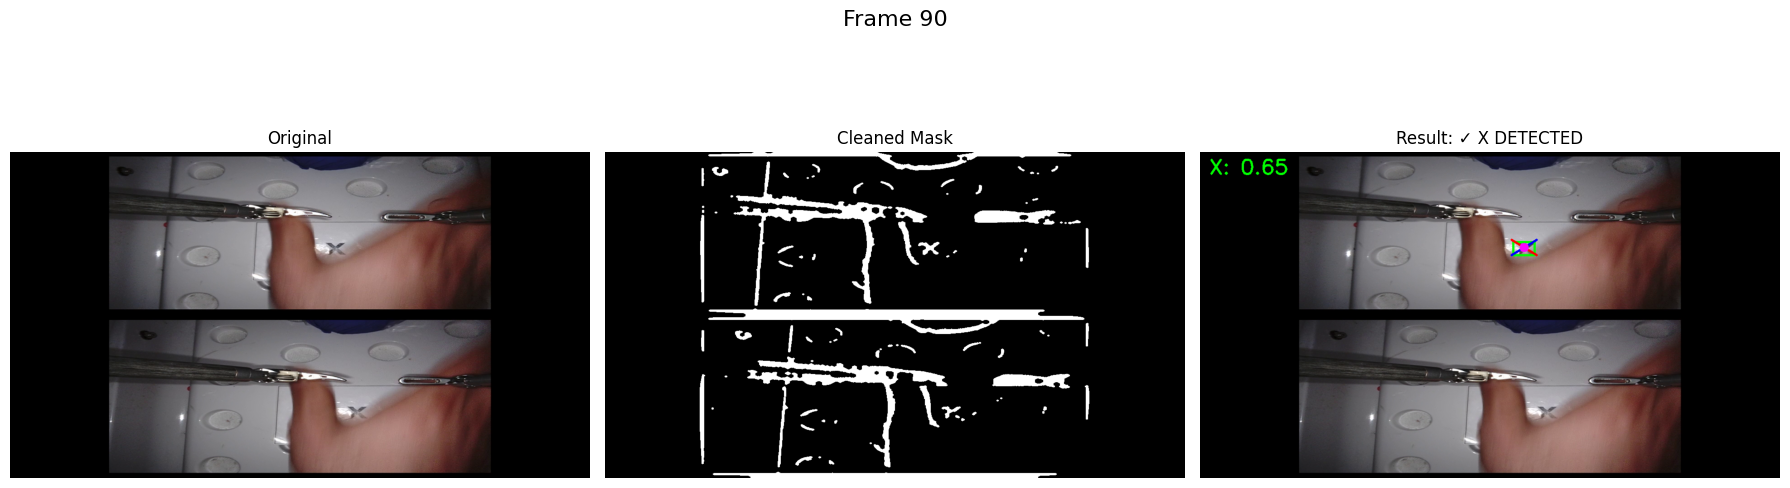

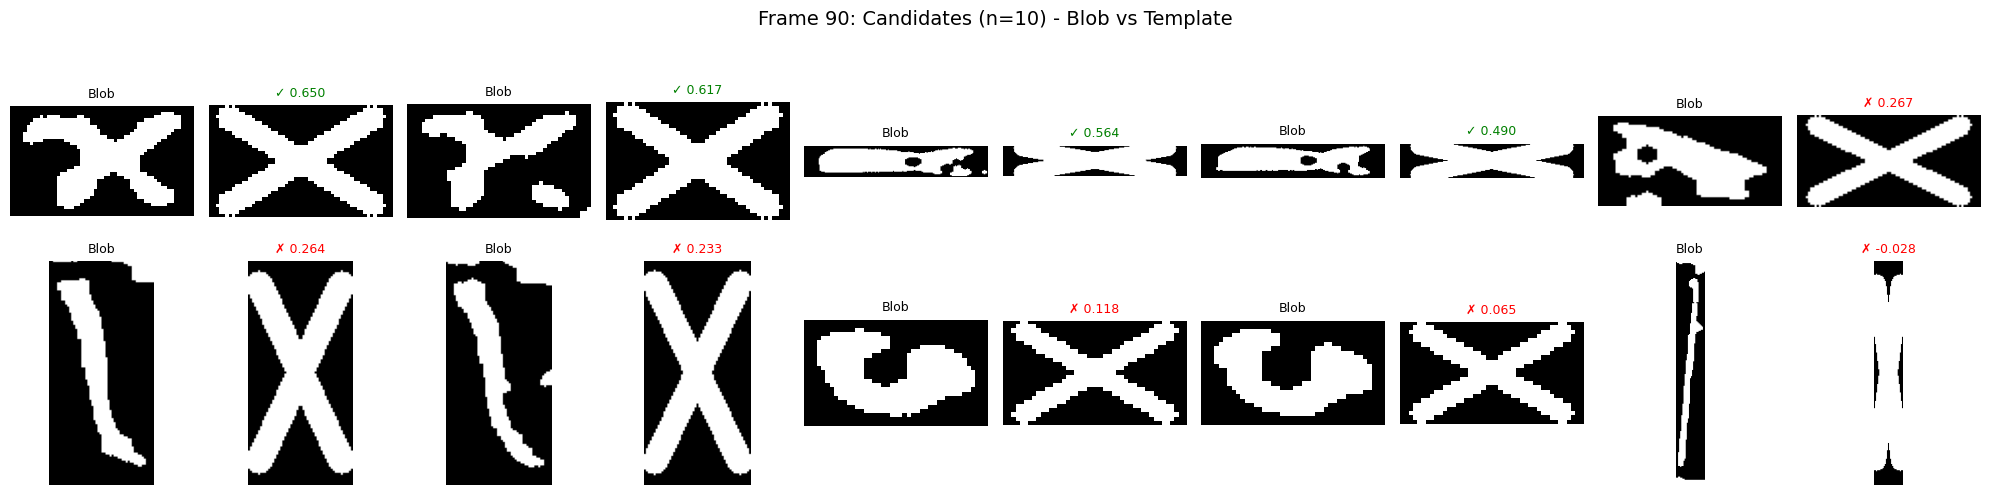


Frame 90:
  X Detected: True
  Match Score: 0.650 (threshold: 0.4)
  Template: 56x34px (thickness: 6px)
  Blob area: 647 pixels
  Total candidates: 10
  Score range: [-0.028, 0.650]



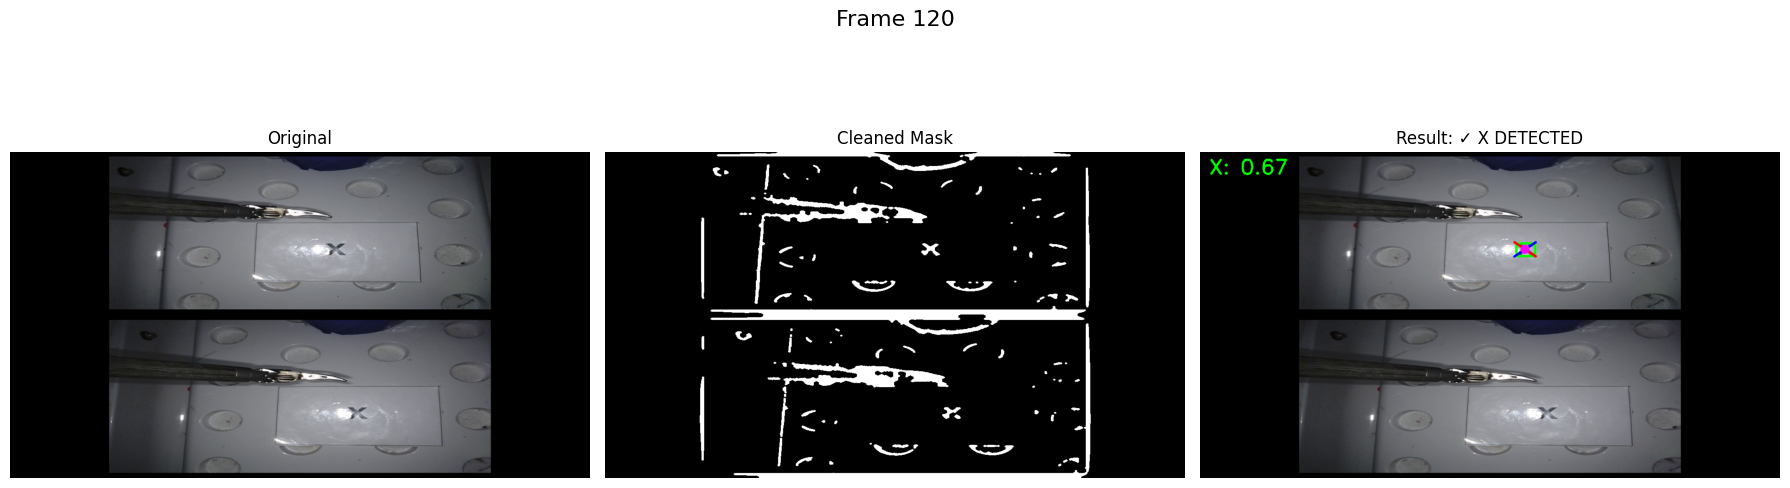

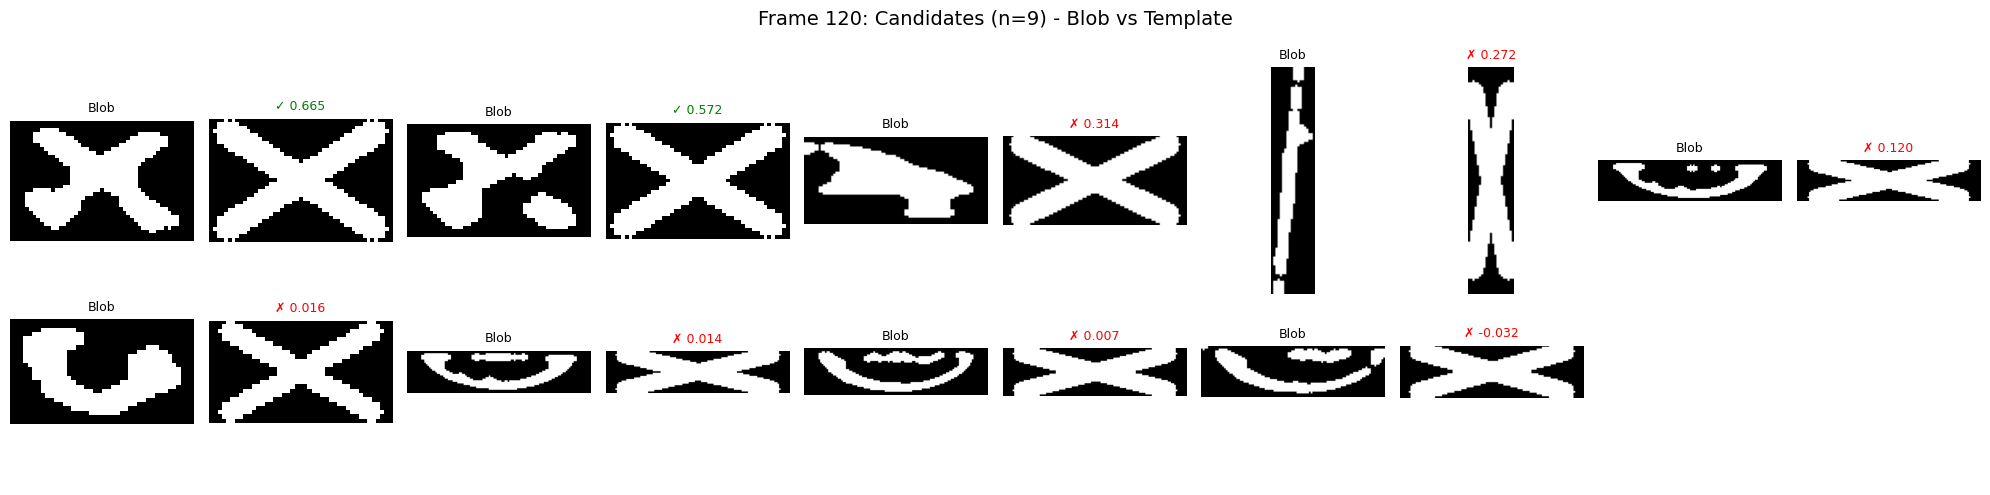


Frame 120:
  X Detected: True
  Match Score: 0.665 (threshold: 0.4)
  Template: 49x33px (thickness: 5px)
  Blob area: 570 pixels
  Total candidates: 9
  Score range: [-0.032, 0.665]



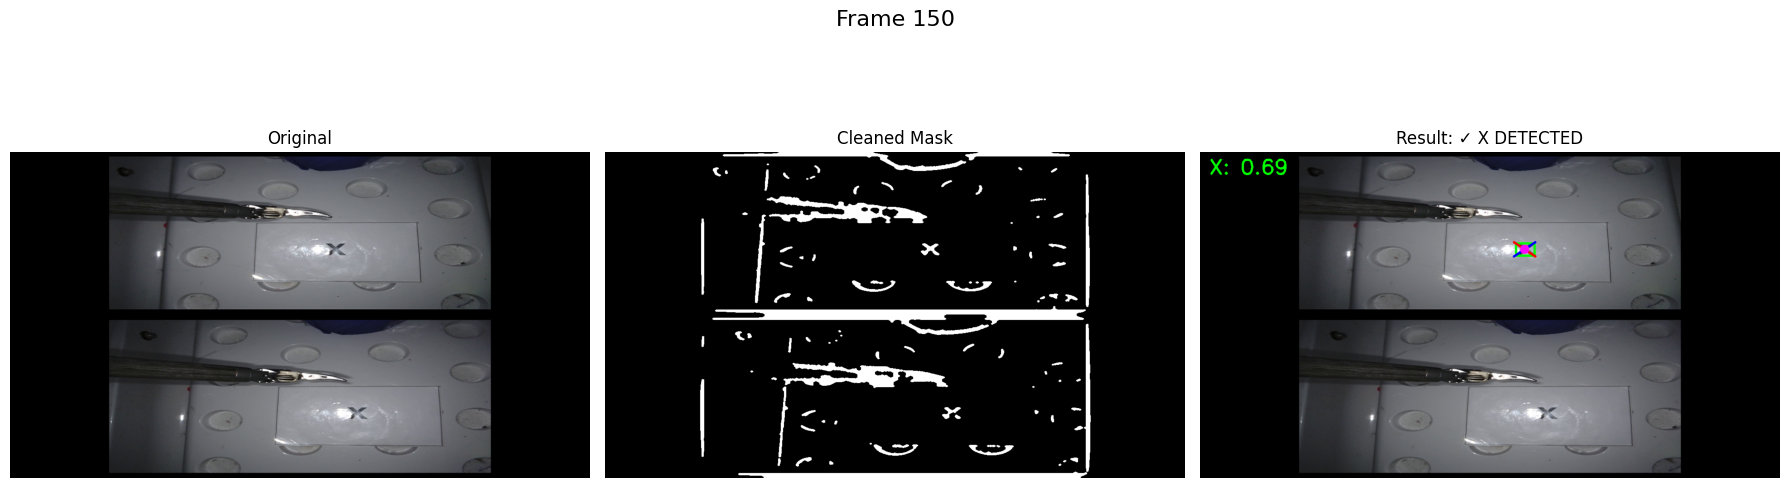

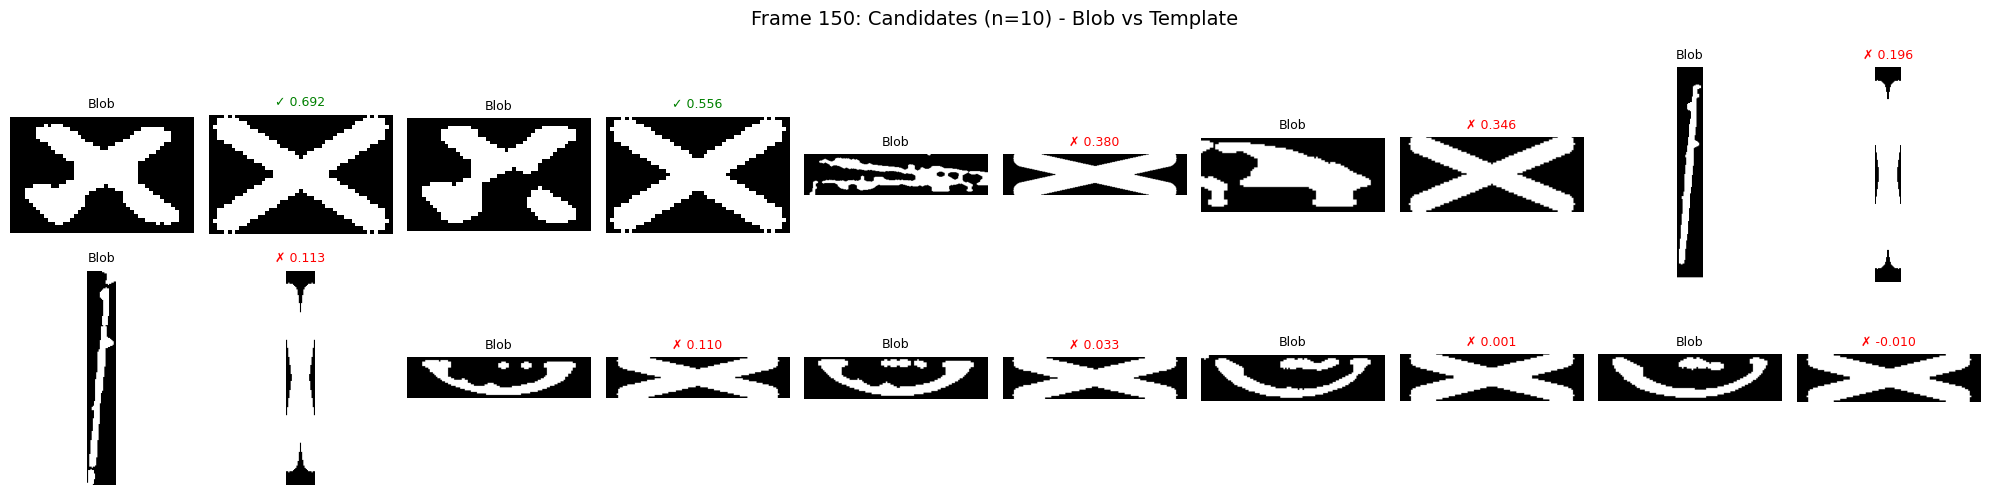


Frame 150:
  X Detected: True
  Match Score: 0.692 (threshold: 0.4)
  Template: 49x32px (thickness: 5px)
  Blob area: 558 pixels
  Total candidates: 10
  Score range: [-0.010, 0.692]



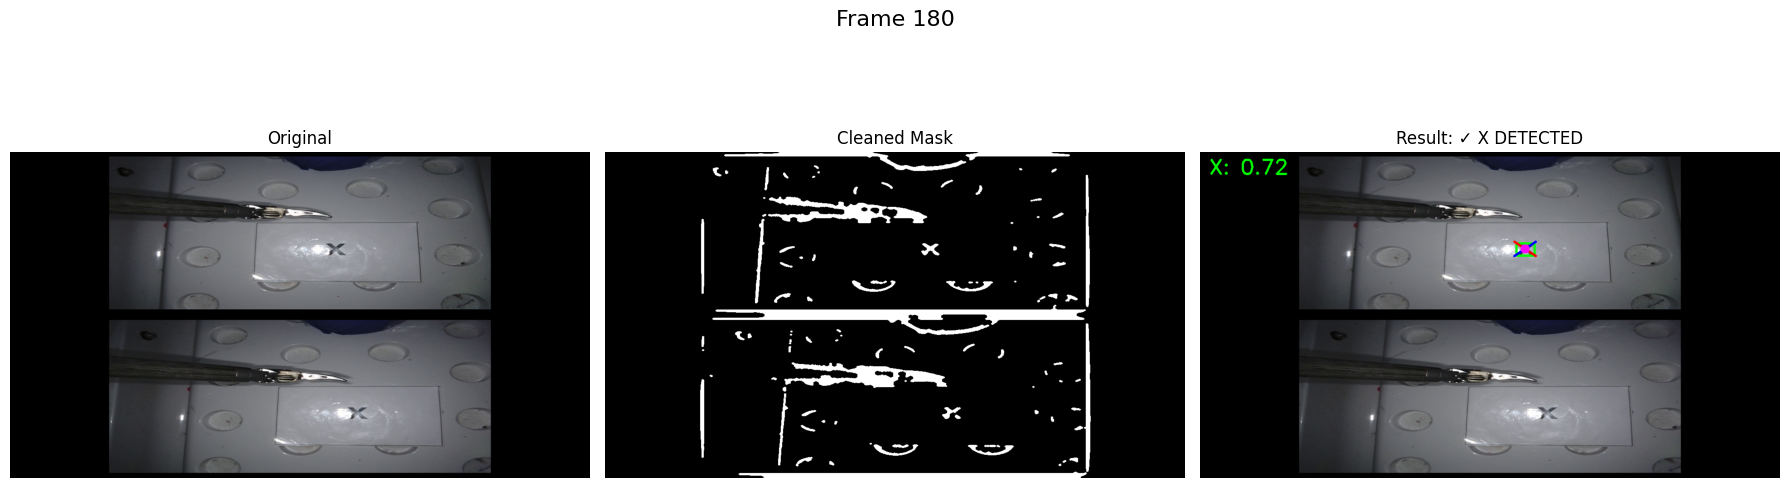

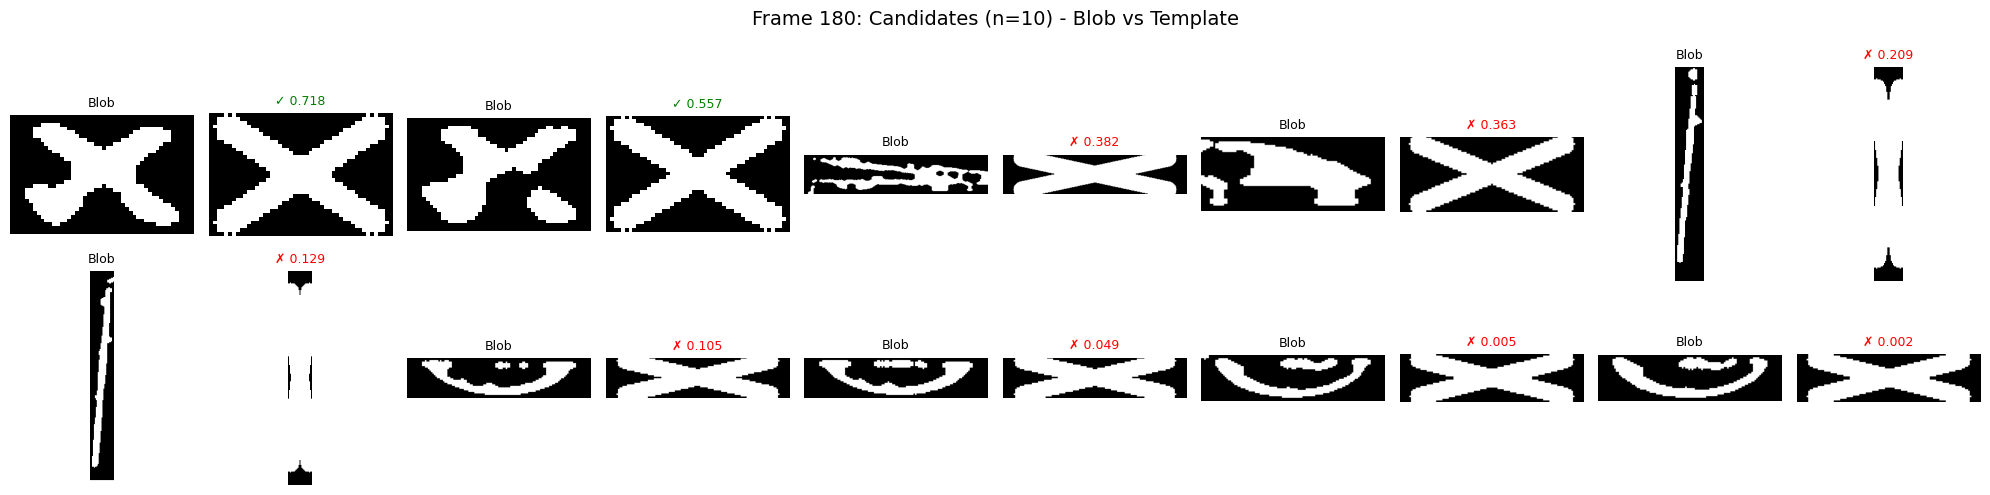


Frame 180:
  X Detected: True
  Match Score: 0.718 (threshold: 0.4)
  Template: 48x32px (thickness: 5px)
  Blob area: 557 pixels
  Total candidates: 10
  Score range: [0.002, 0.718]



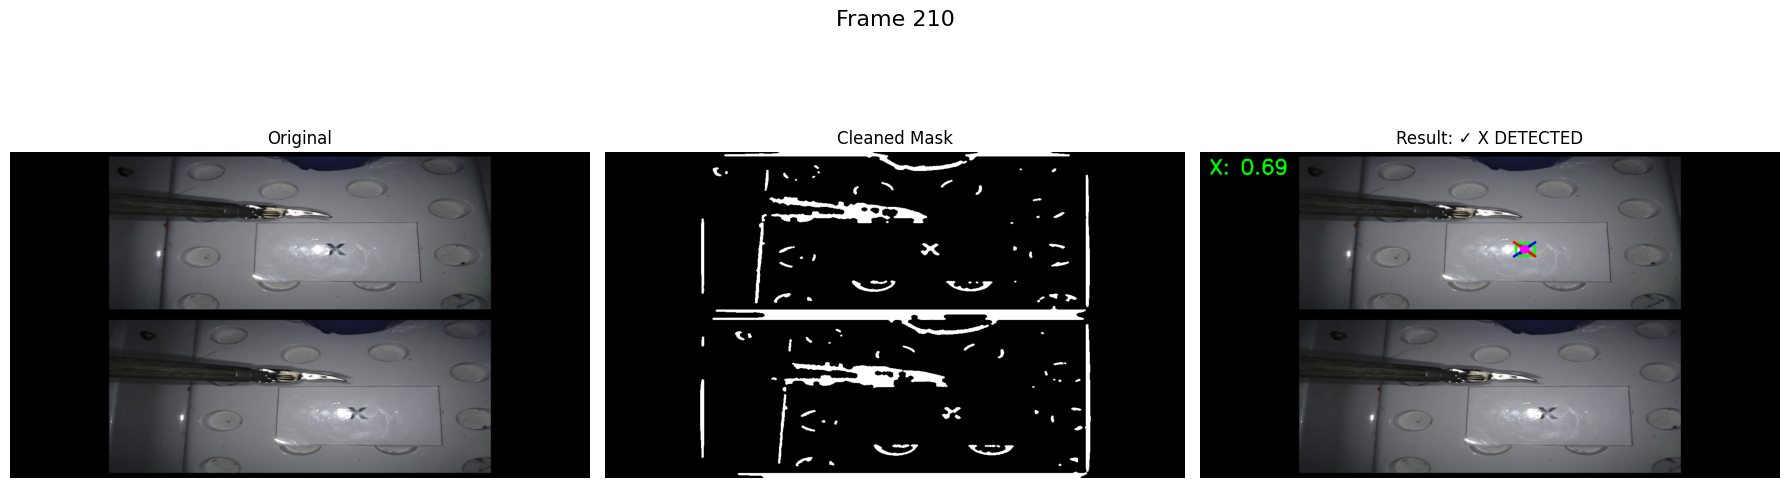

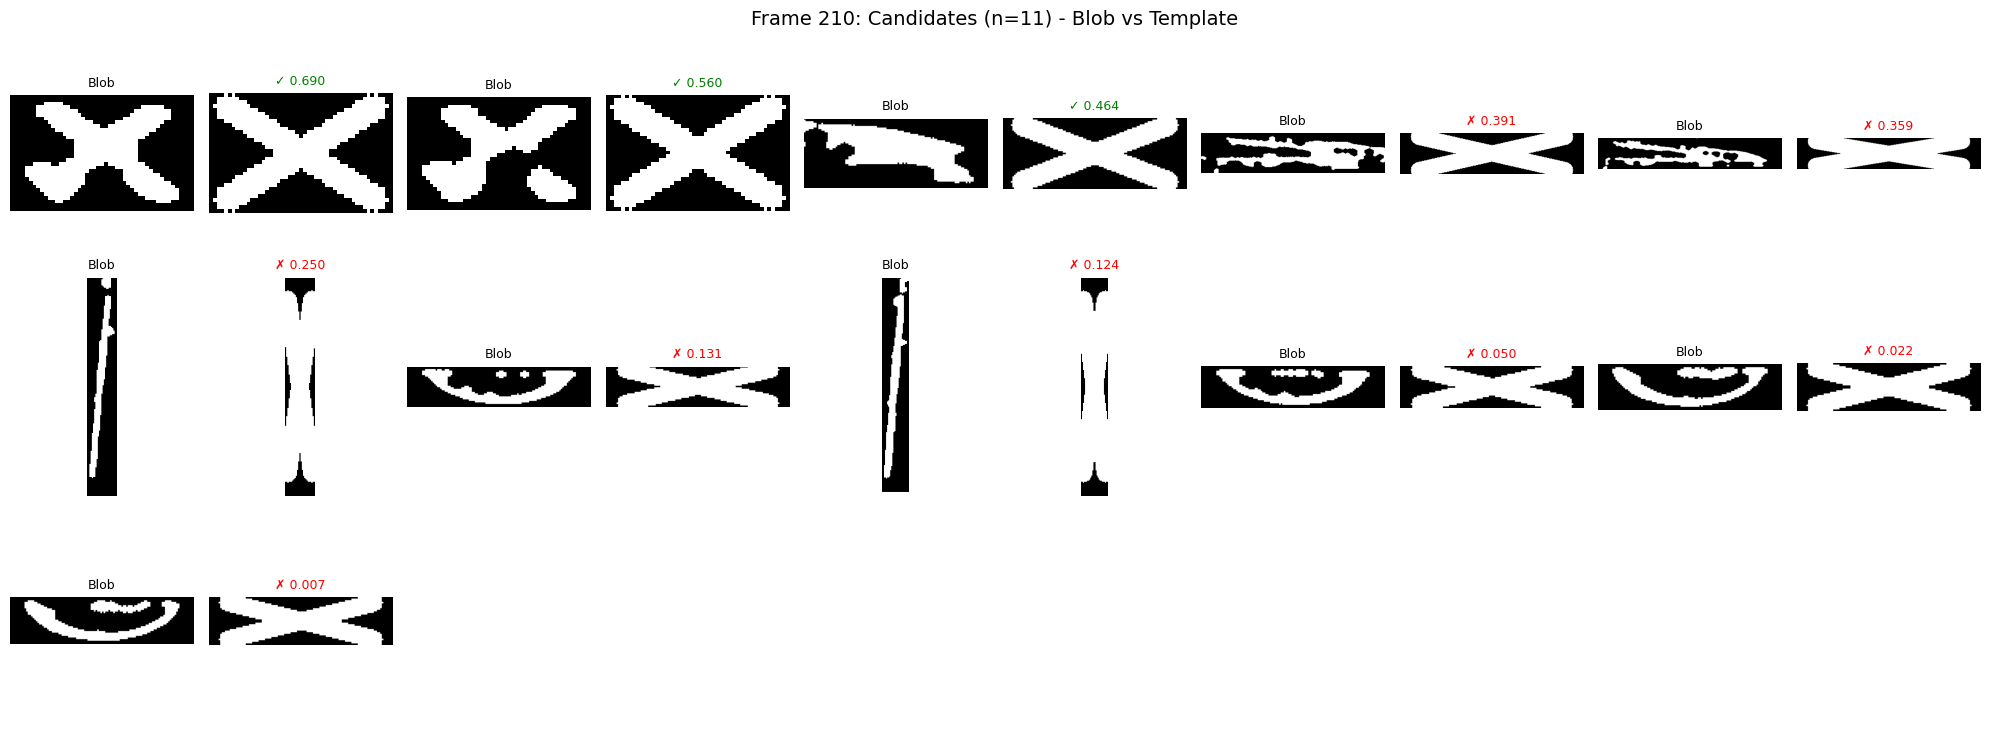


Frame 210:
  X Detected: True
  Match Score: 0.690 (threshold: 0.4)
  Template: 49x32px (thickness: 5px)
  Blob area: 559 pixels
  Total candidates: 11
  Score range: [0.007, 0.690]



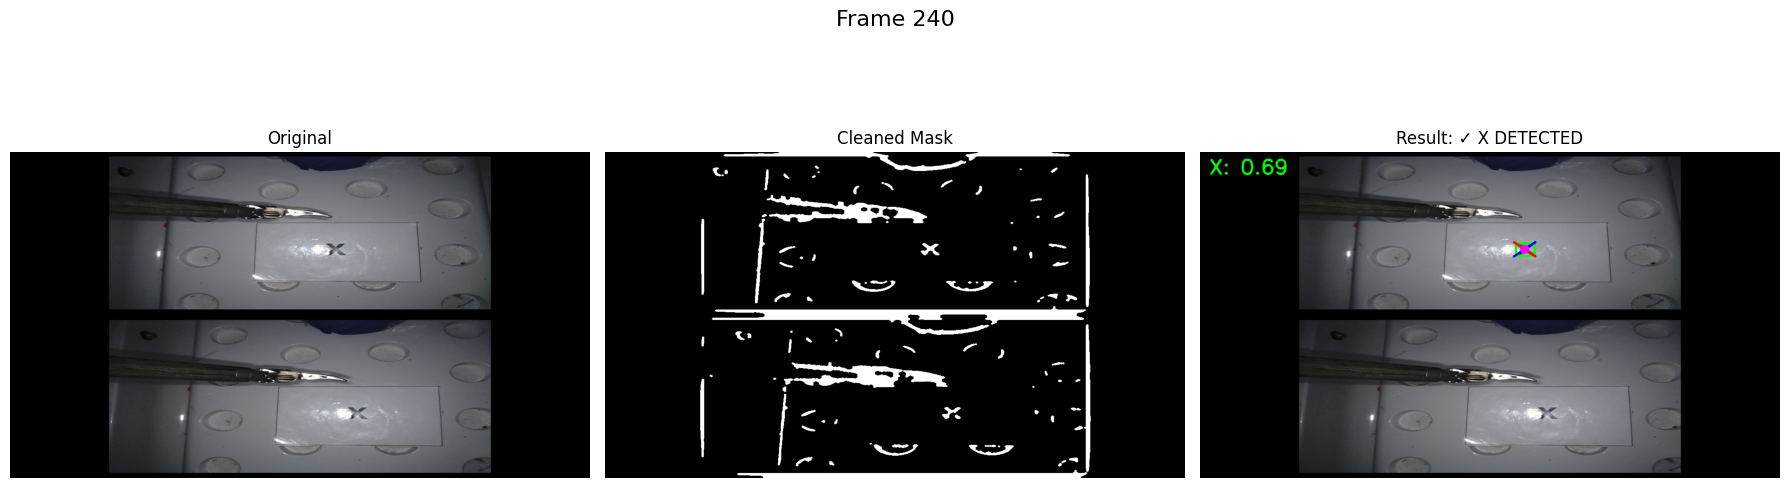

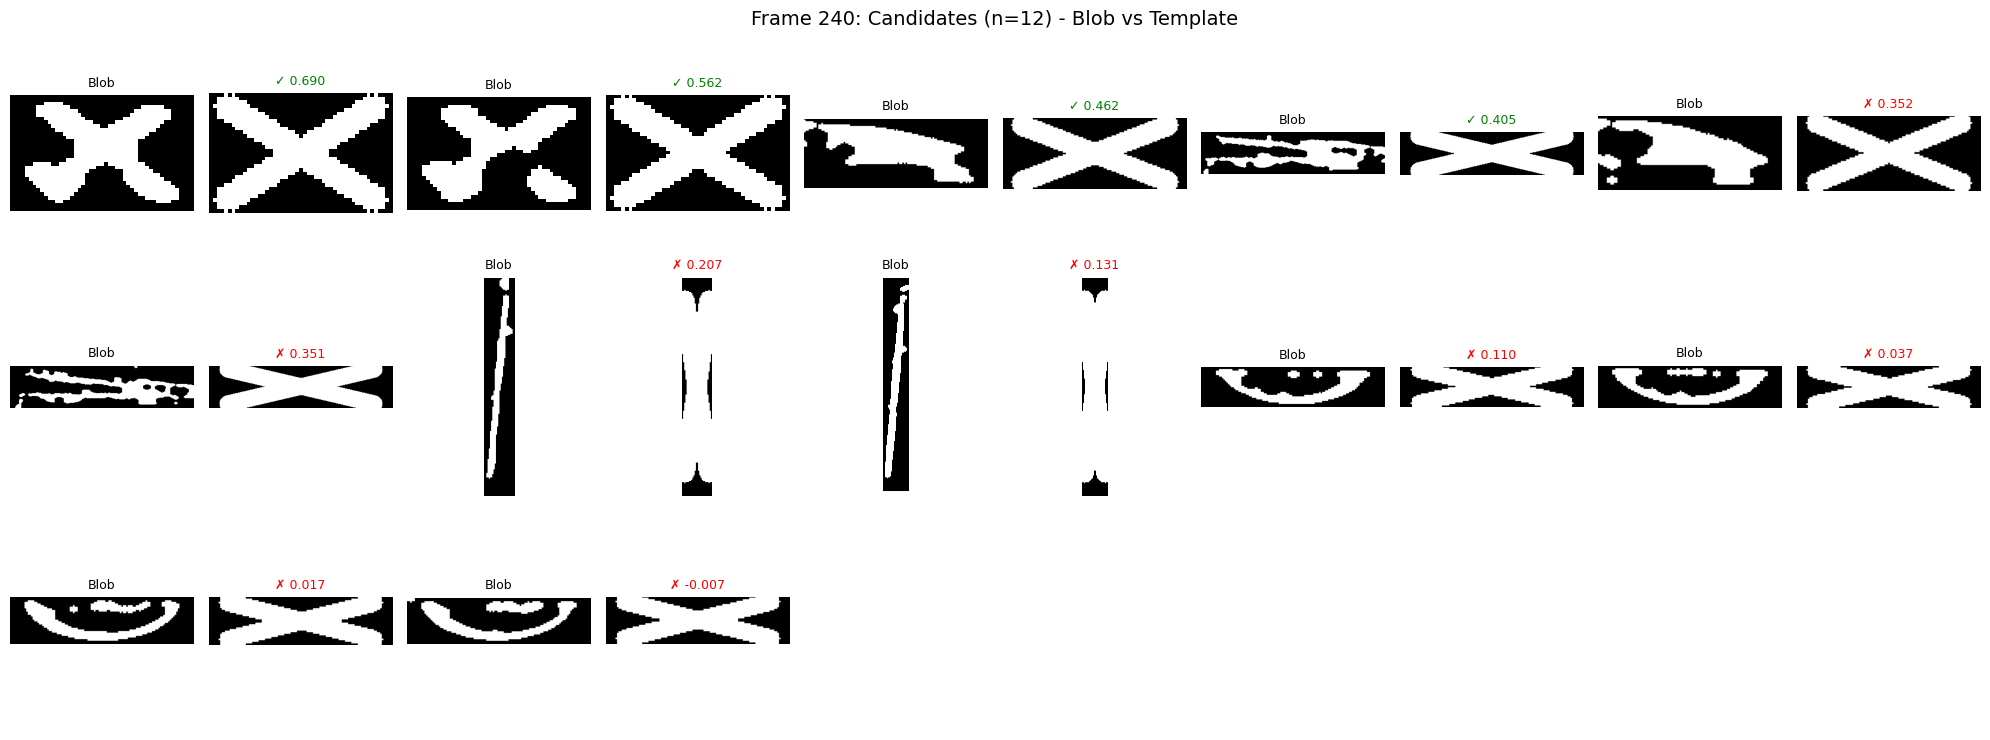


Frame 240:
  X Detected: True
  Match Score: 0.690 (threshold: 0.4)
  Template: 49x32px (thickness: 5px)
  Blob area: 559 pixels
  Total candidates: 12
  Score range: [-0.007, 0.690]



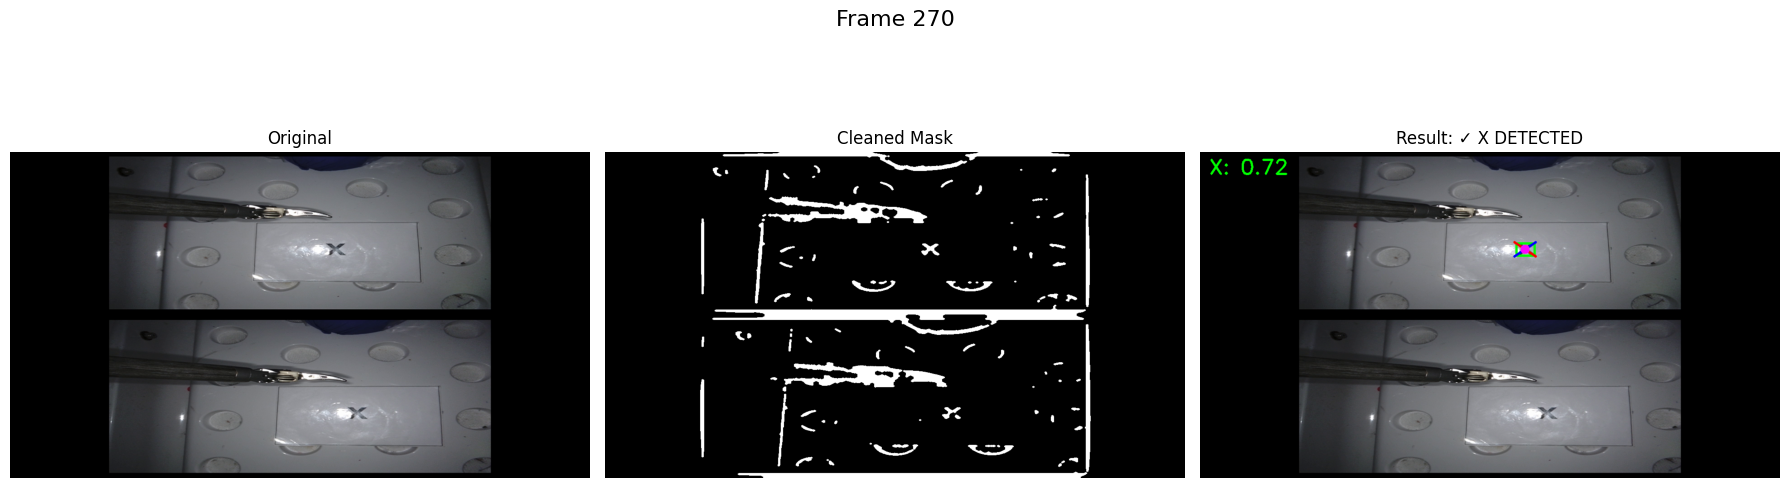

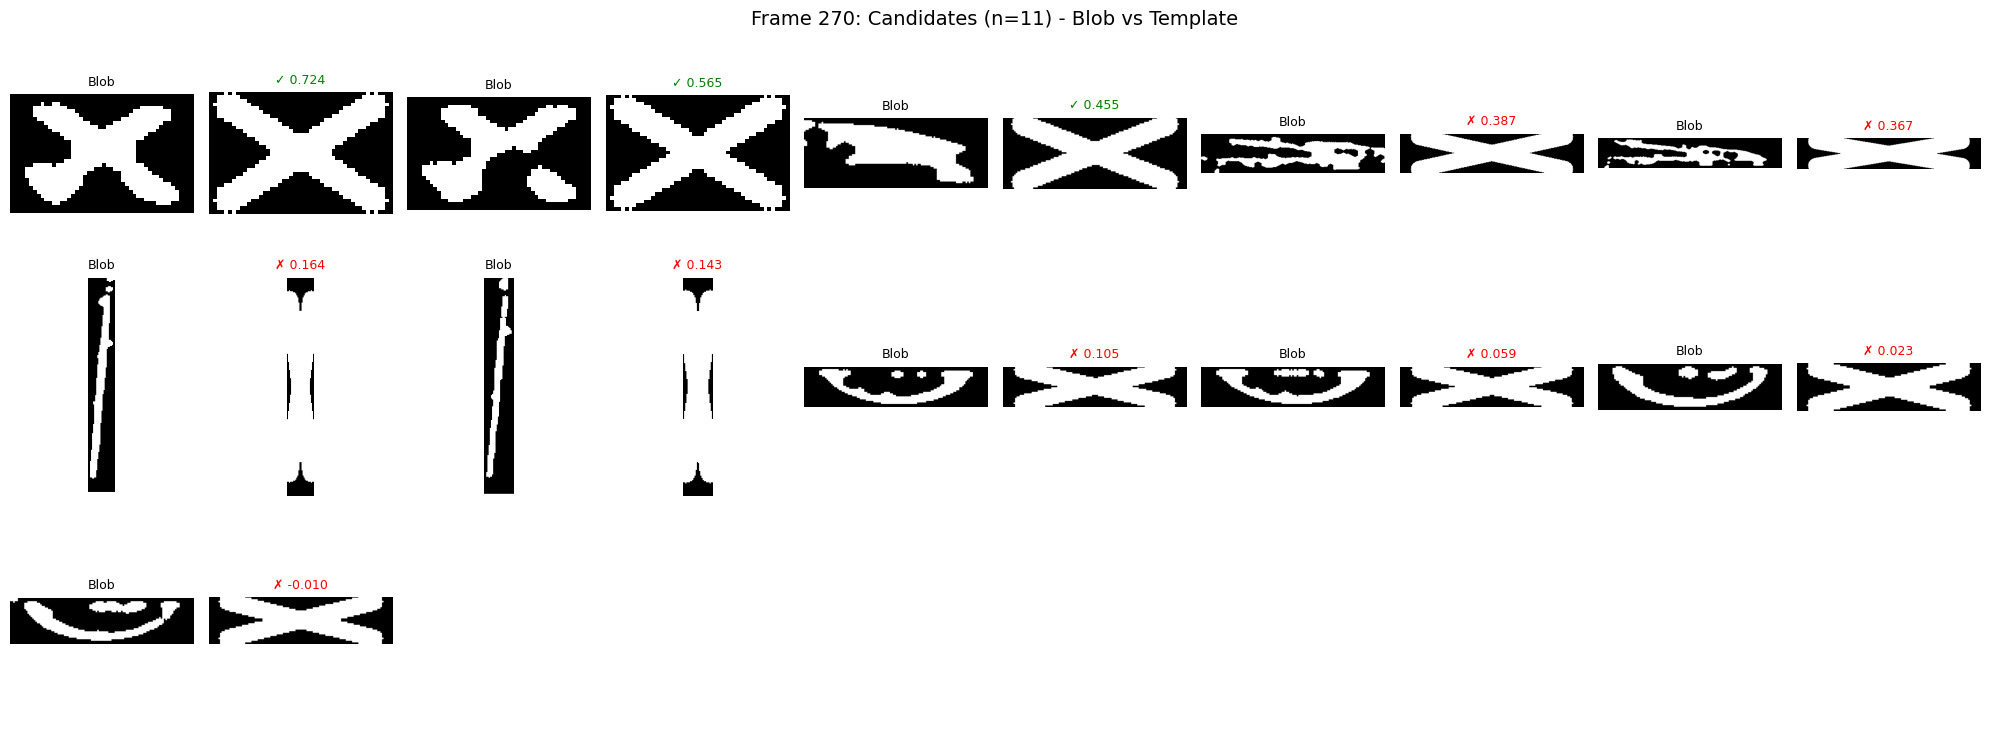


Frame 270:
  X Detected: True
  Match Score: 0.724 (threshold: 0.4)
  Template: 48x32px (thickness: 5px)
  Blob area: 554 pixels
  Total candidates: 11
  Score range: [-0.010, 0.724]



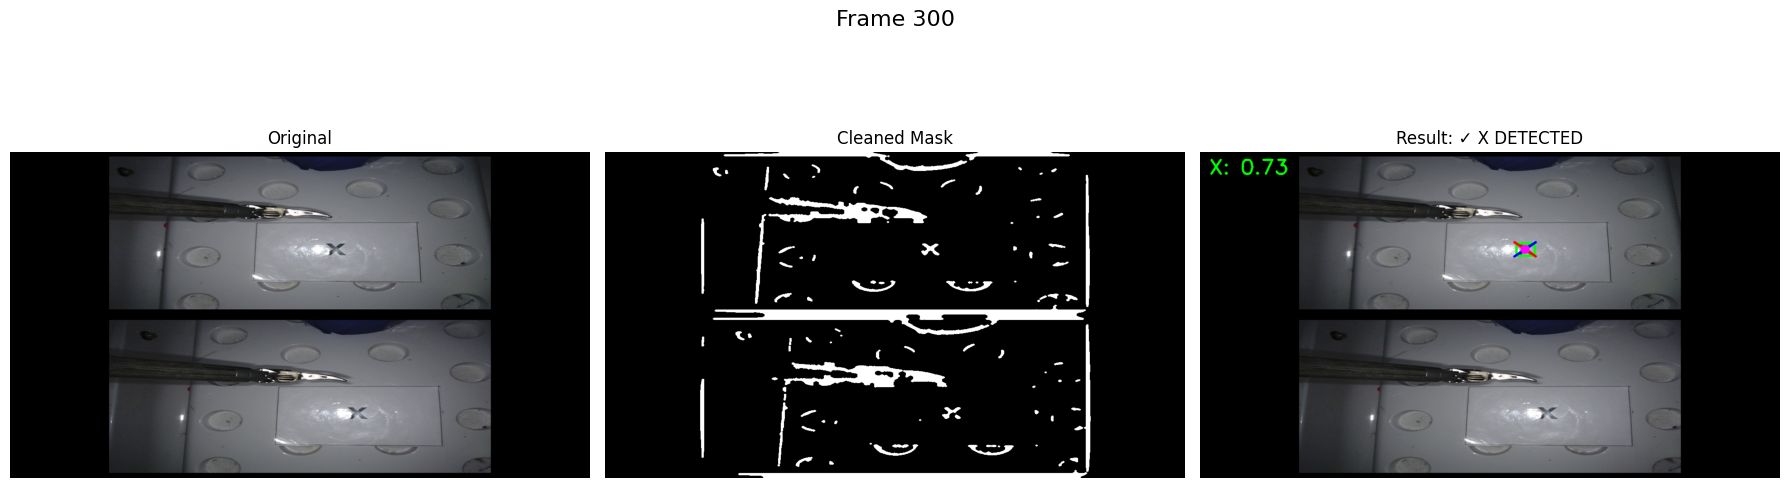

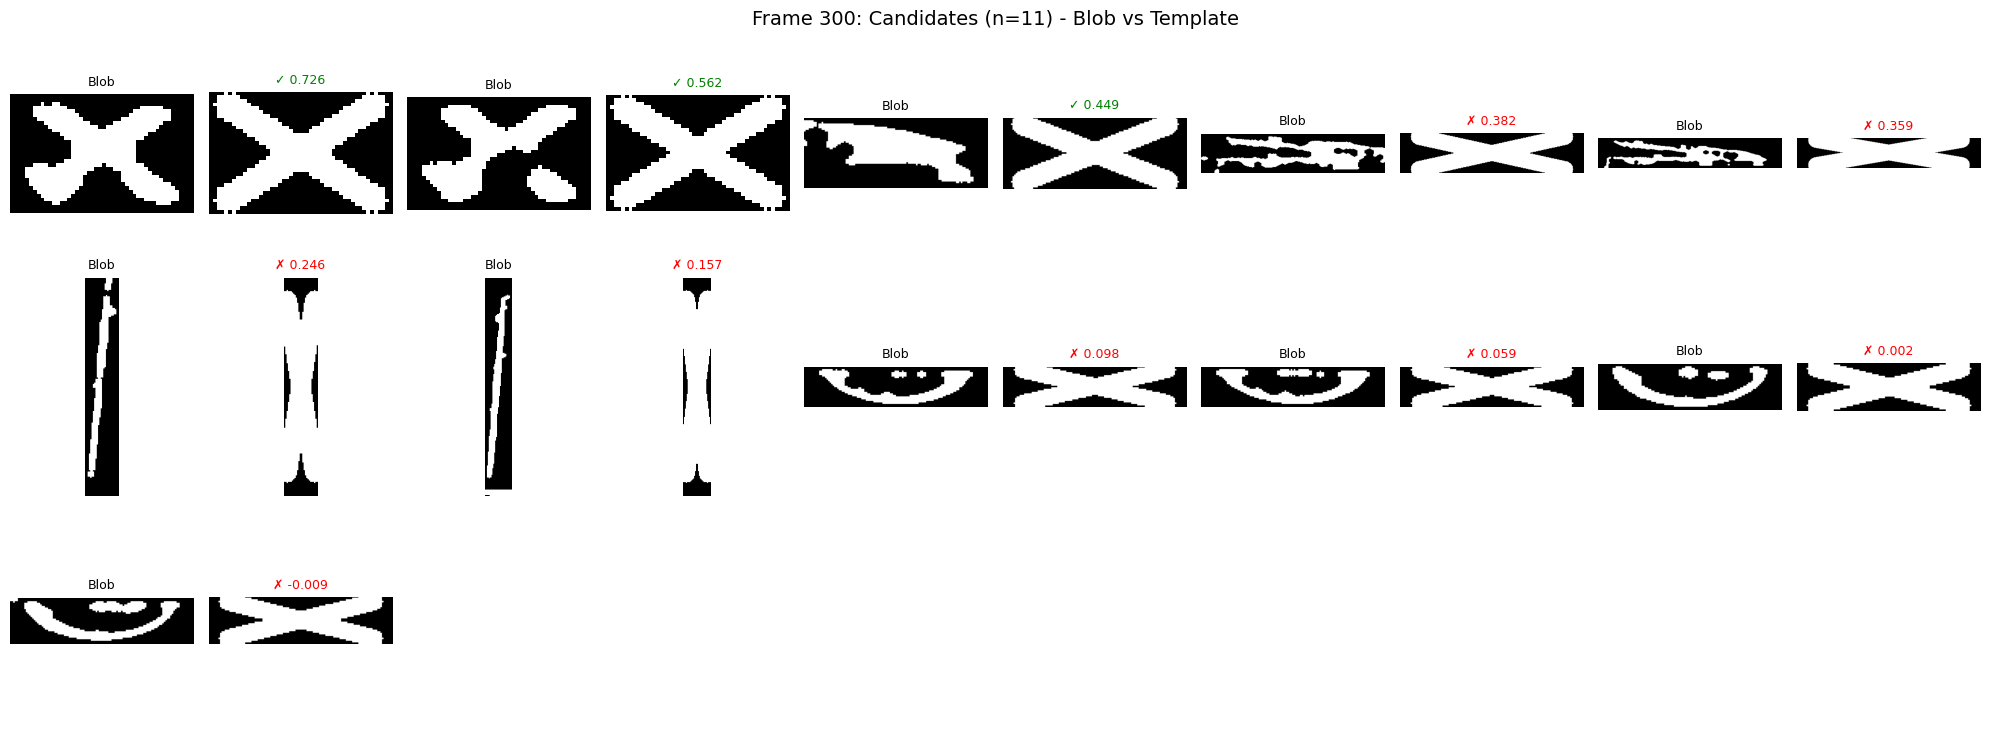


Frame 300:
  X Detected: True
  Match Score: 0.726 (threshold: 0.4)
  Template: 48x32px (thickness: 5px)
  Blob area: 553 pixels
  Total candidates: 11
  Score range: [-0.009, 0.726]



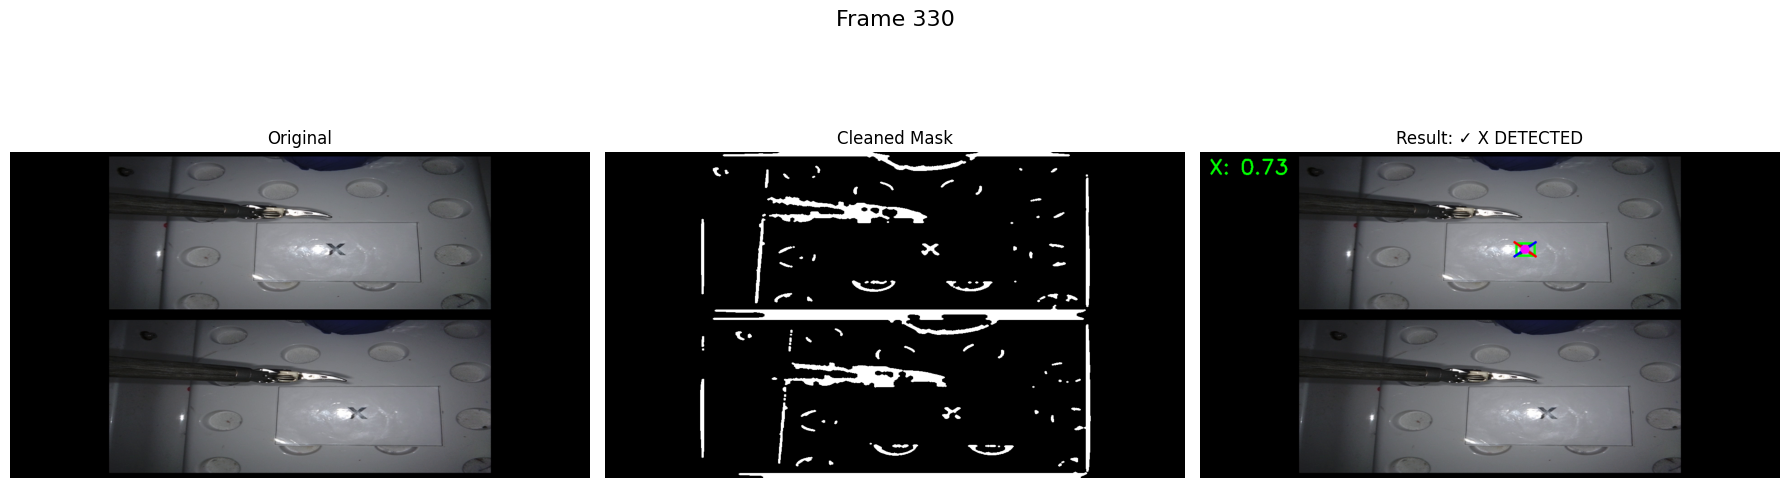

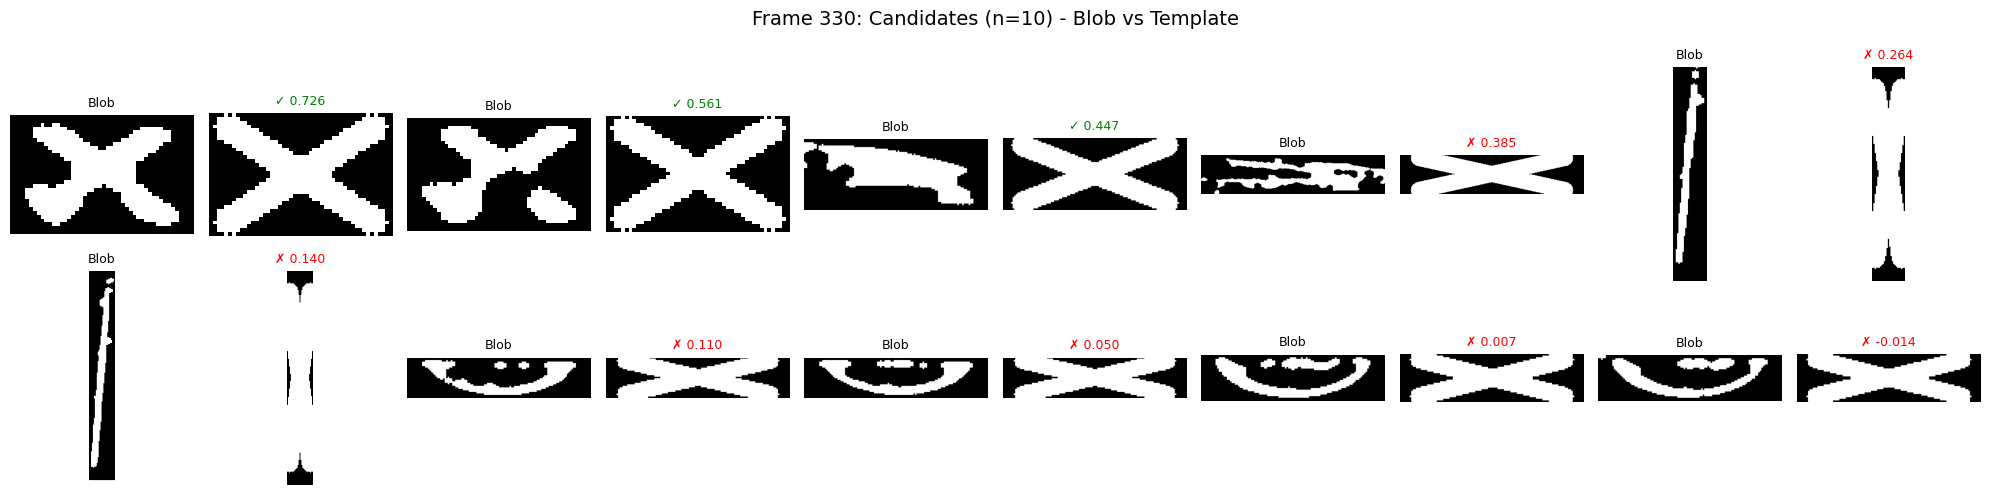


Frame 330:
  X Detected: True
  Match Score: 0.726 (threshold: 0.4)
  Template: 48x32px (thickness: 5px)
  Blob area: 553 pixels
  Total candidates: 10
  Score range: [-0.014, 0.726]



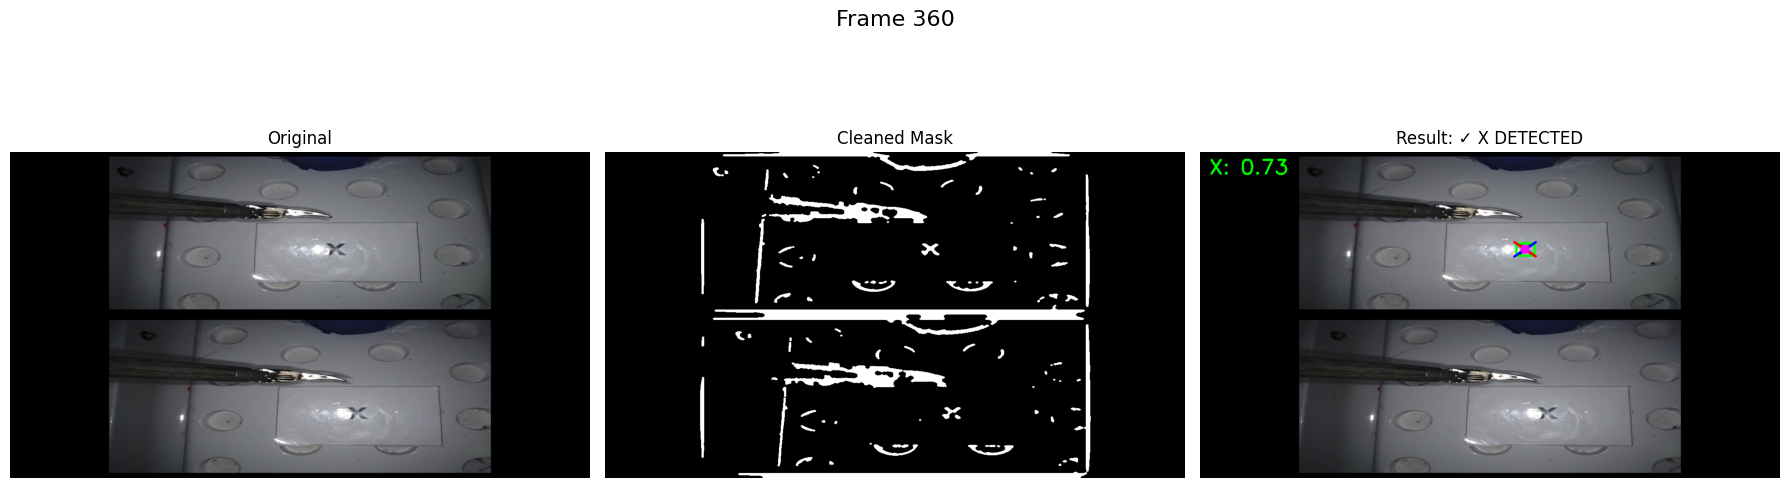

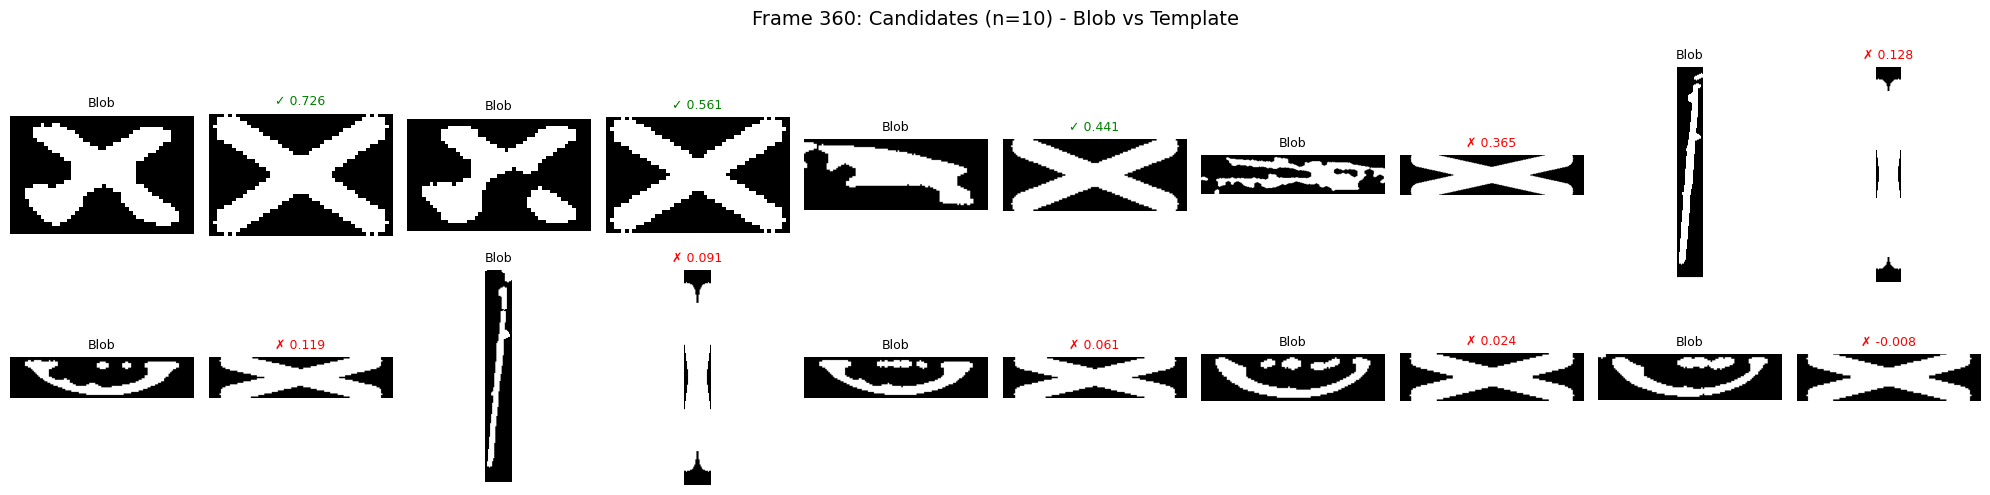


Frame 360:
  X Detected: True
  Match Score: 0.726 (threshold: 0.4)
  Template: 48x32px (thickness: 5px)
  Blob area: 553 pixels
  Total candidates: 10
  Score range: [-0.008, 0.726]



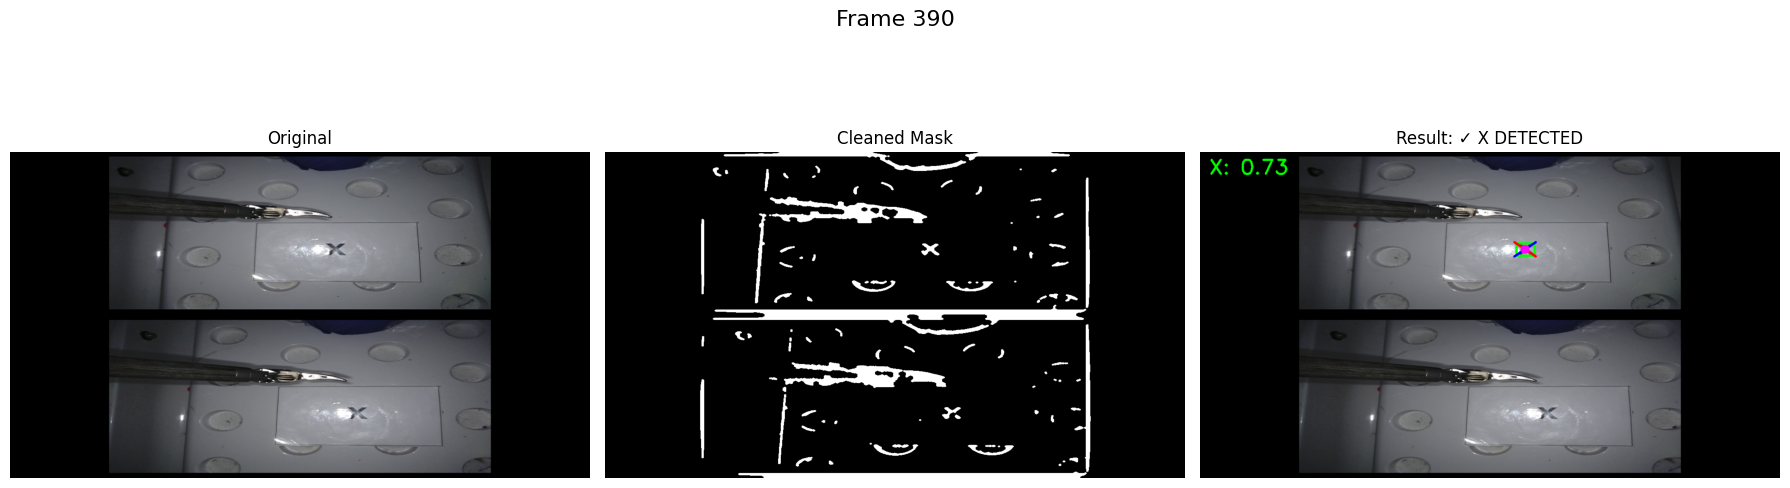

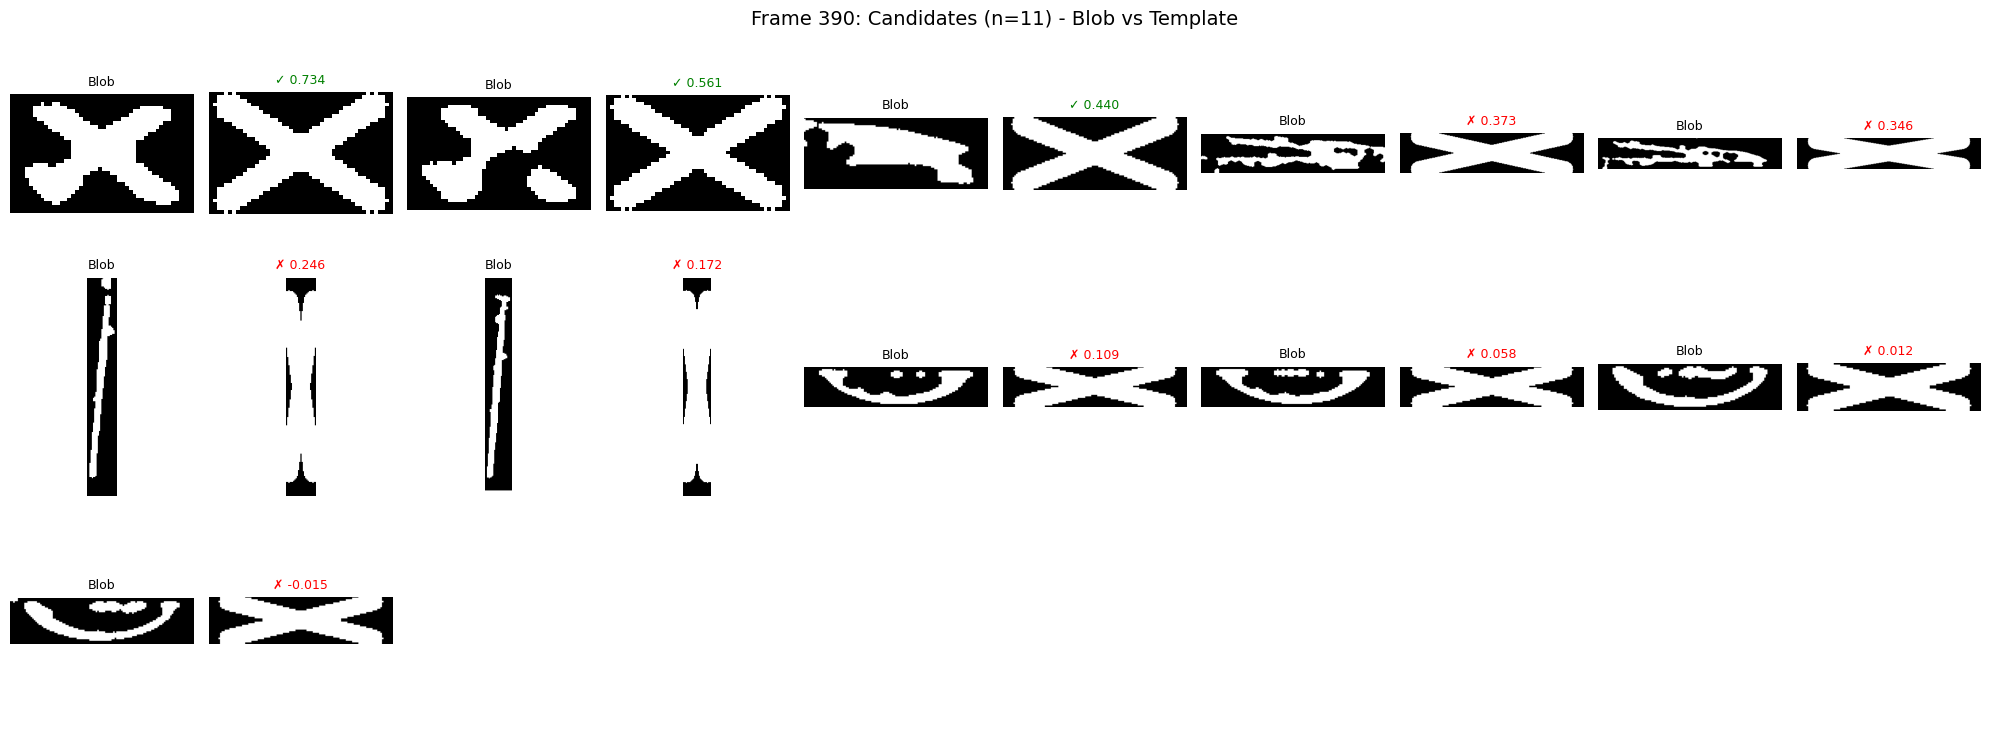


Frame 390:
  X Detected: True
  Match Score: 0.734 (threshold: 0.4)
  Template: 48x32px (thickness: 5px)
  Blob area: 564 pixels
  Total candidates: 11
  Score range: [-0.015, 0.734]



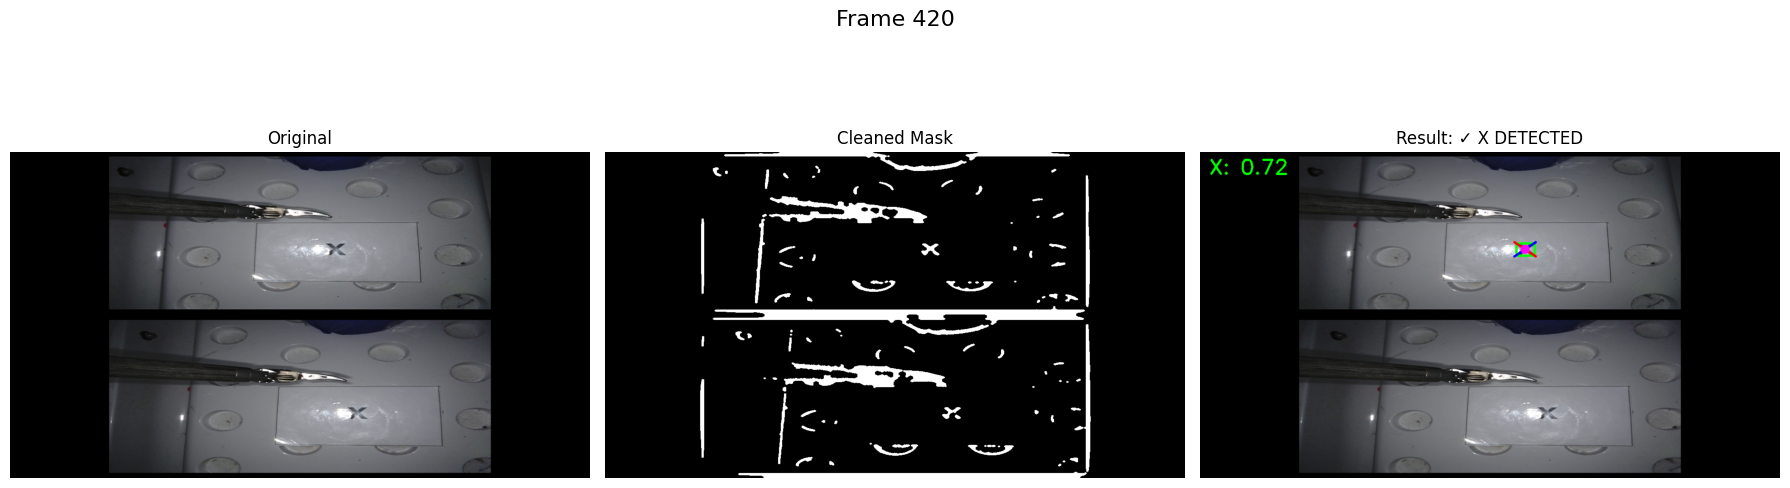

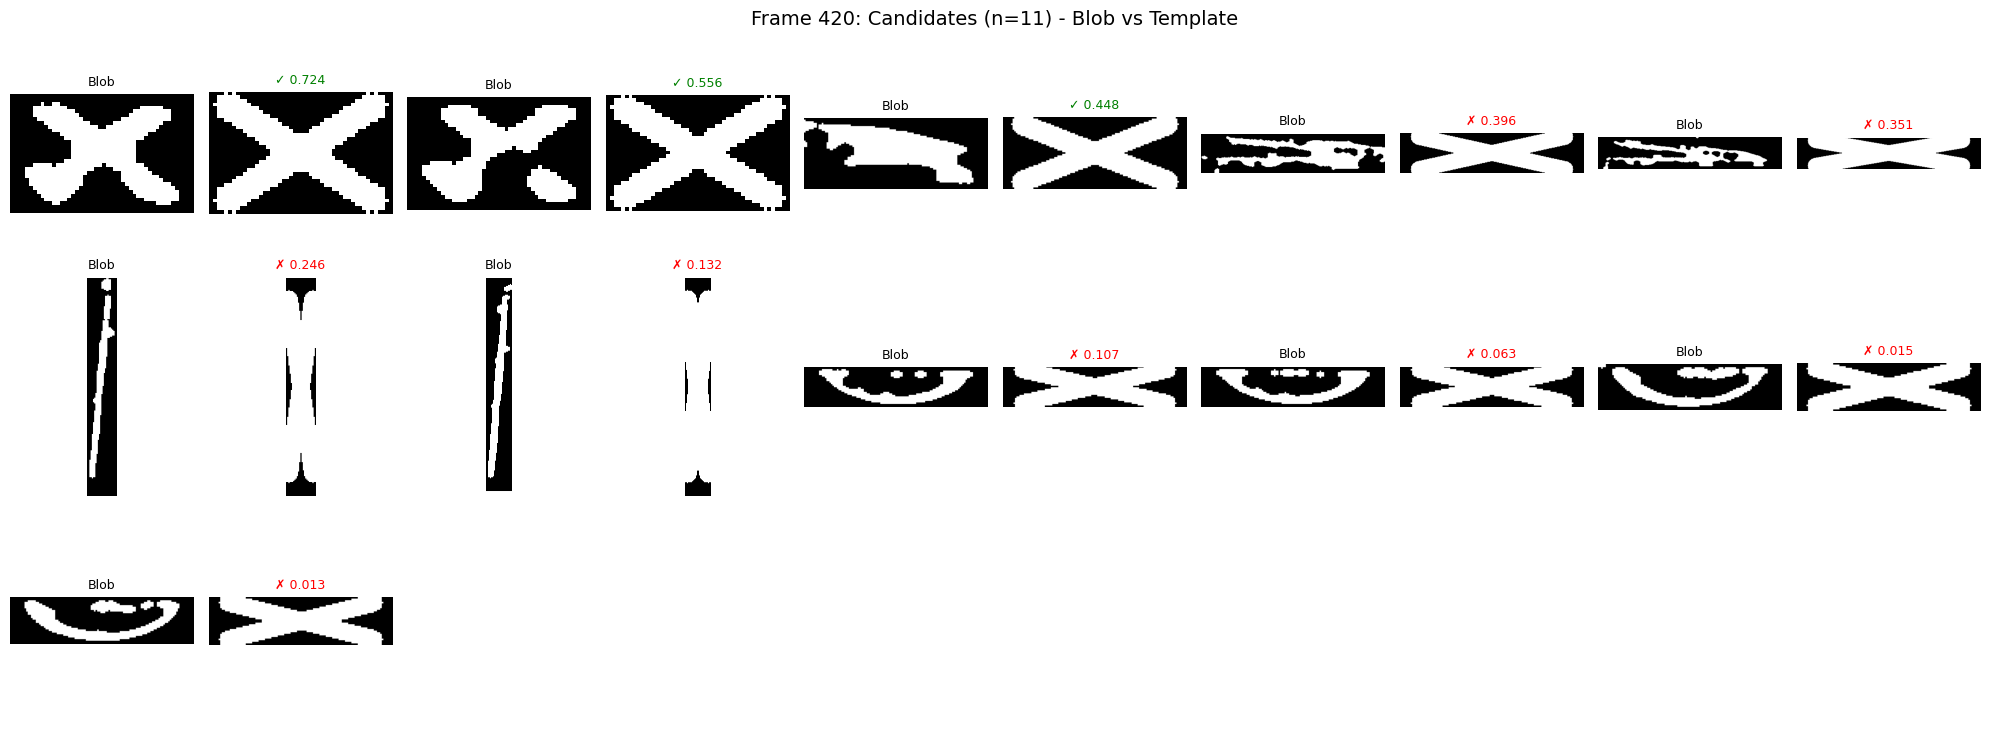


Frame 420:
  X Detected: True
  Match Score: 0.724 (threshold: 0.4)
  Template: 48x32px (thickness: 5px)
  Blob area: 554 pixels
  Total candidates: 11
  Score range: [0.013, 0.724]



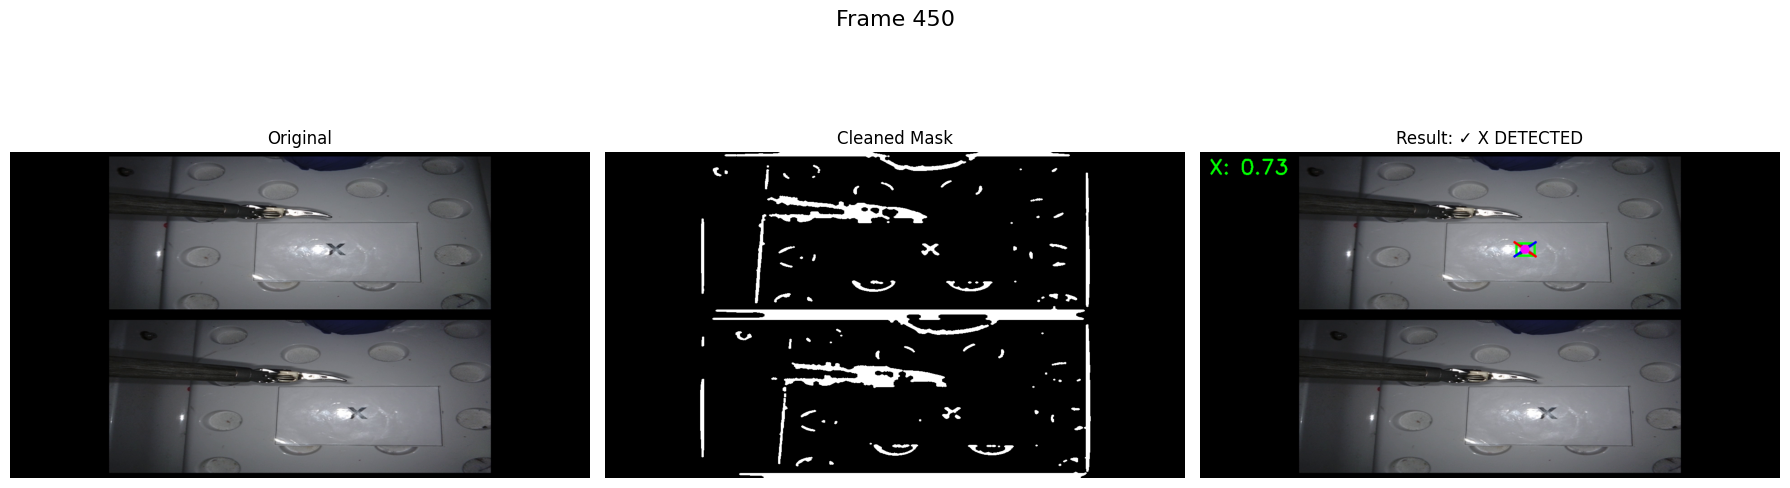

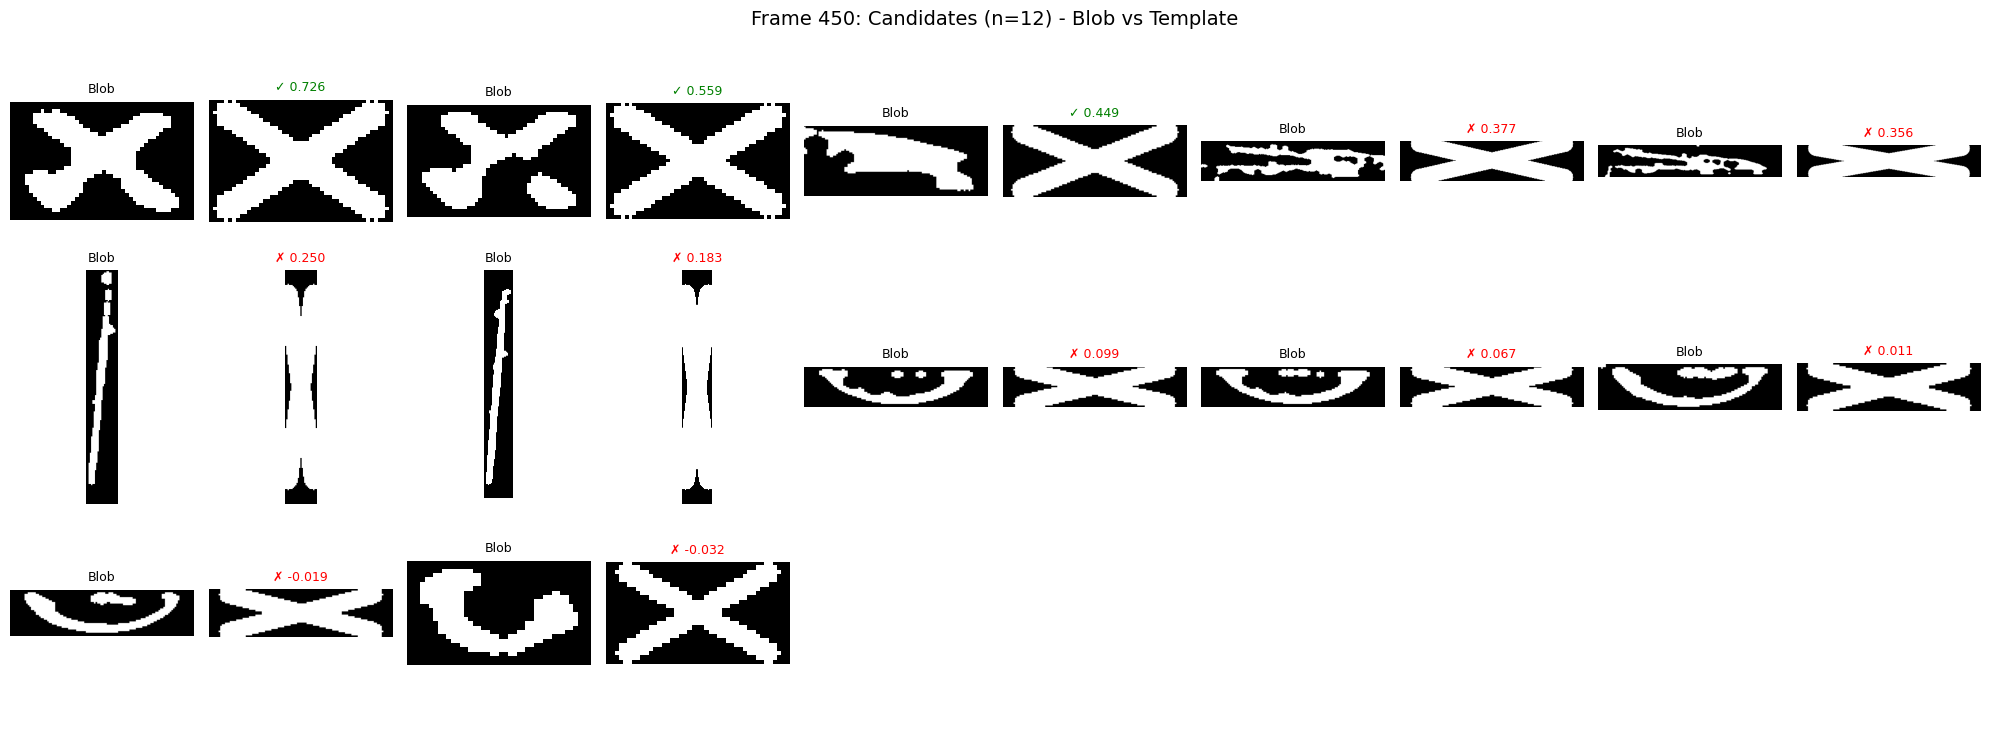


Frame 450:
  X Detected: True
  Match Score: 0.726 (threshold: 0.4)
  Template: 48x32px (thickness: 5px)
  Blob area: 554 pixels
  Total candidates: 12
  Score range: [-0.032, 0.726]



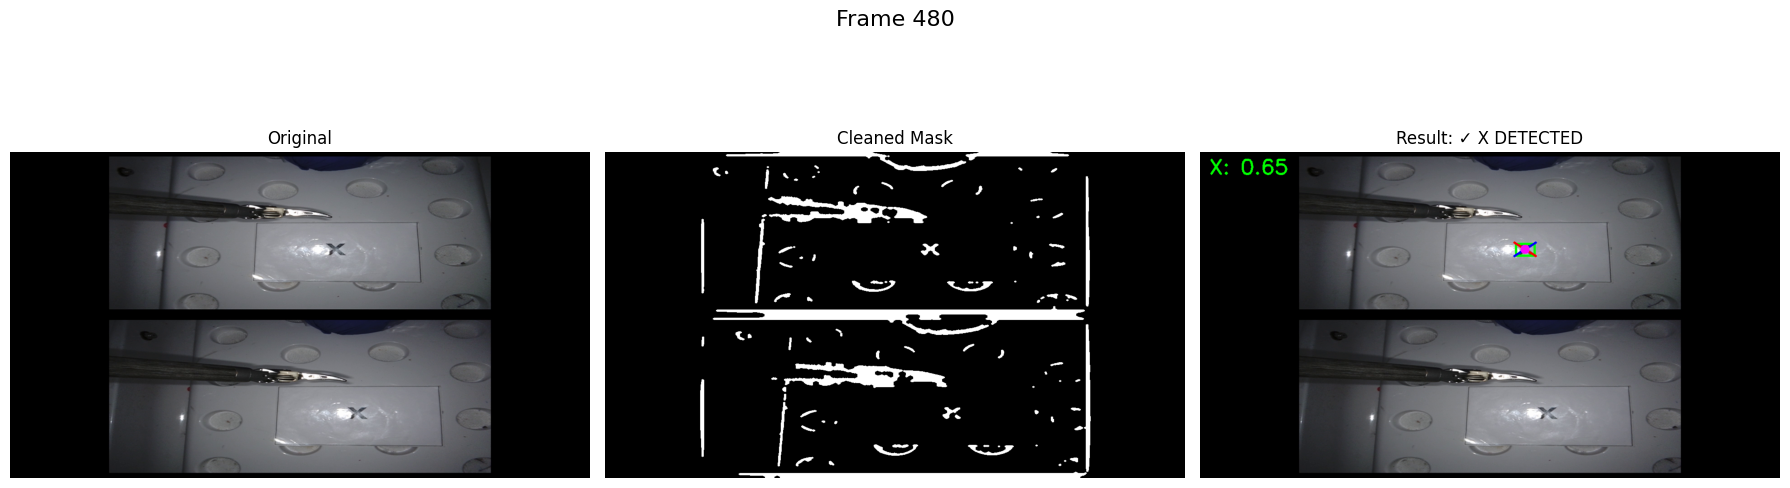

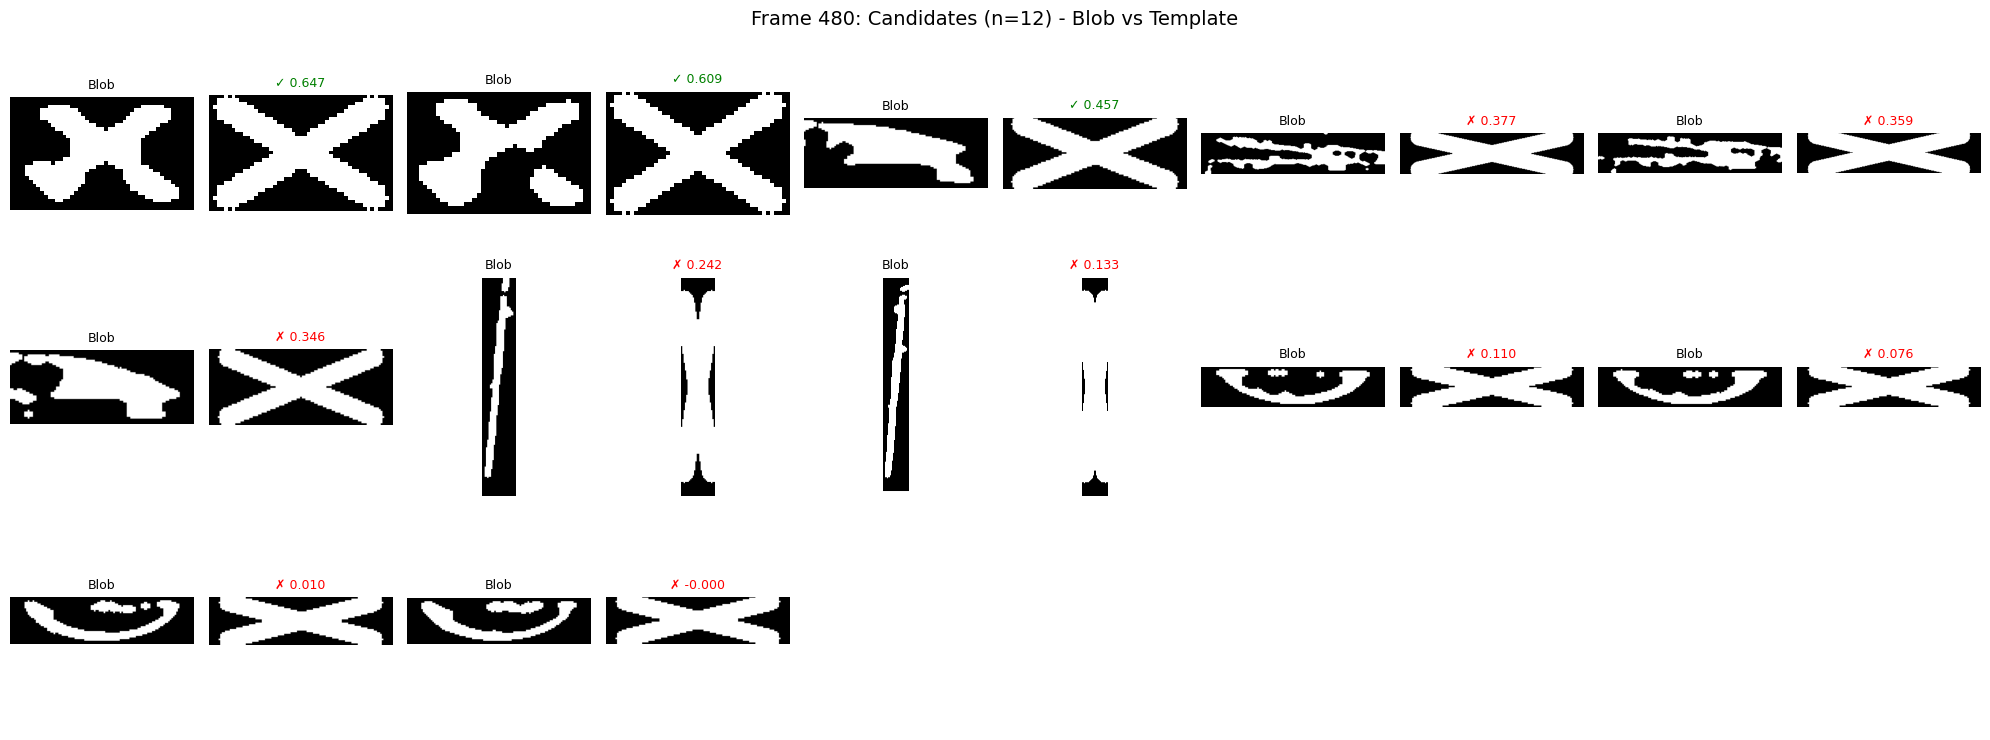


Frame 480:
  X Detected: True
  Match Score: 0.647 (threshold: 0.4)
  Template: 49x31px (thickness: 5px)
  Blob area: 557 pixels
  Total candidates: 12
  Score range: [-0.000, 0.647]



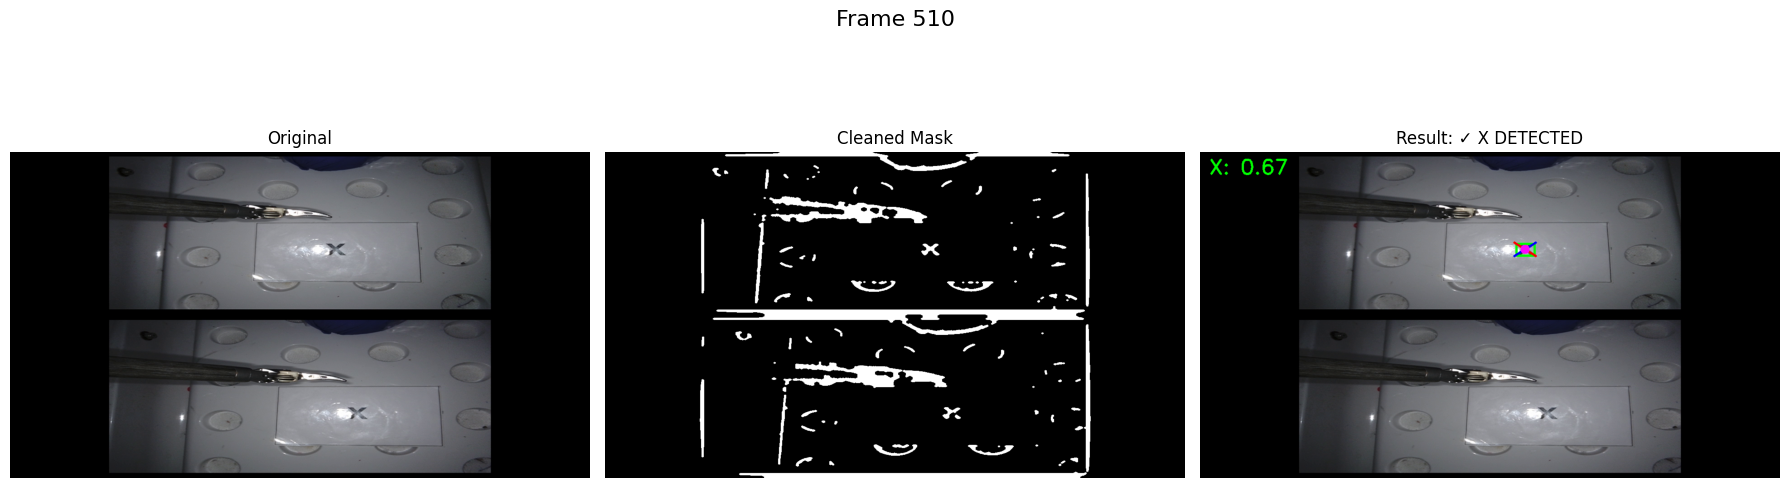

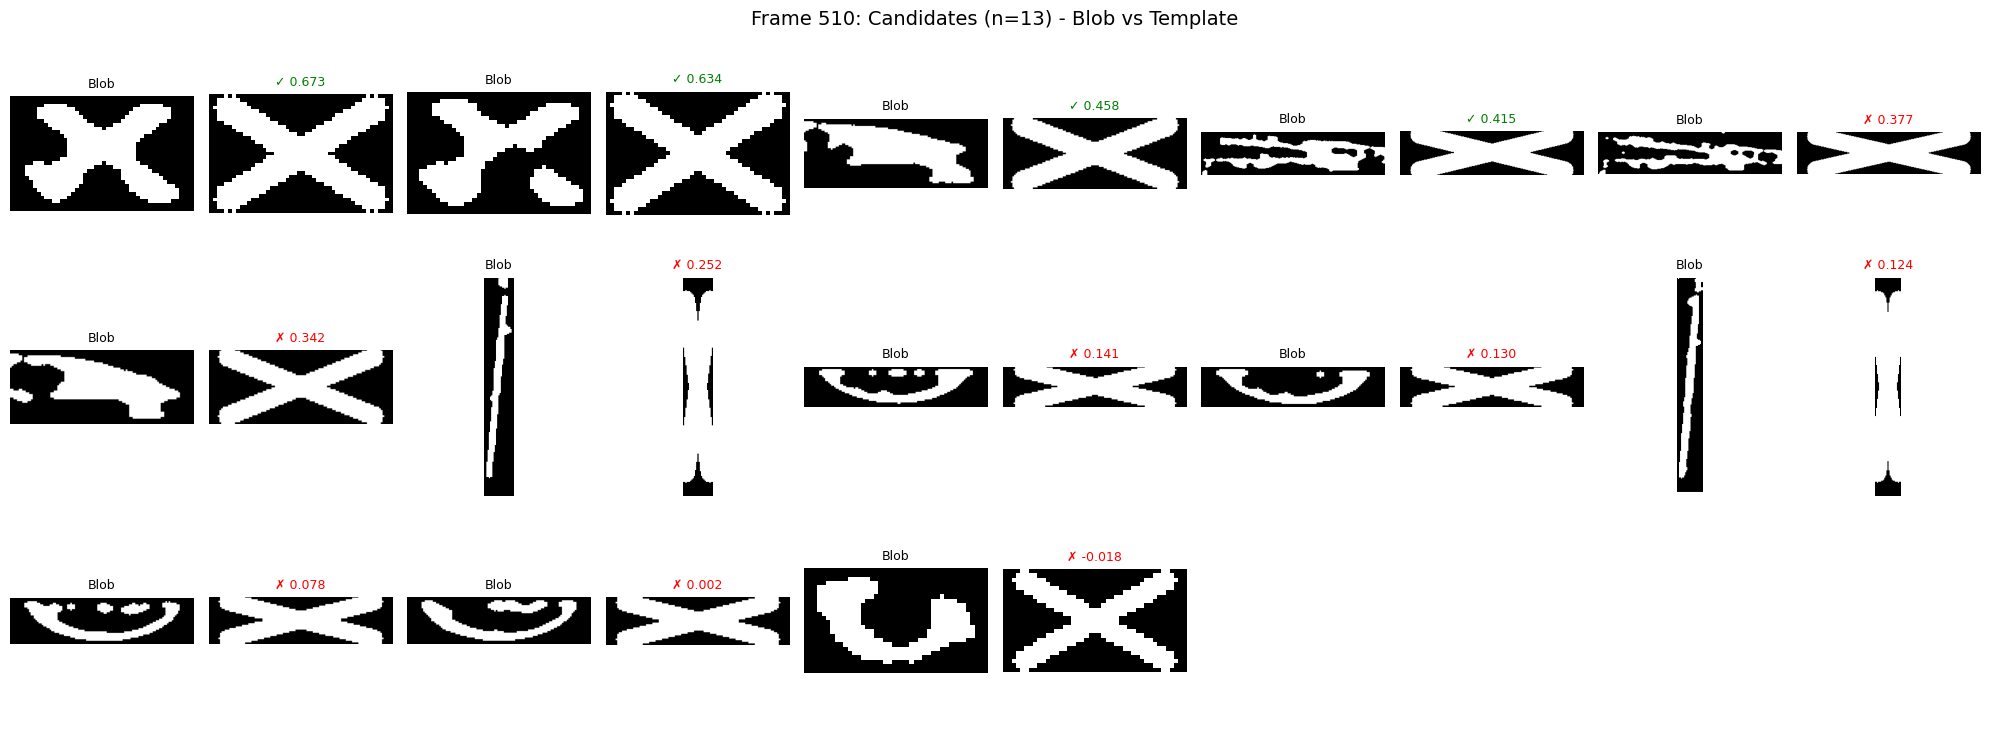


Frame 510:
  X Detected: True
  Match Score: 0.673 (threshold: 0.4)
  Template: 48x31px (thickness: 5px)
  Blob area: 547 pixels
  Total candidates: 13
  Score range: [-0.018, 0.673]



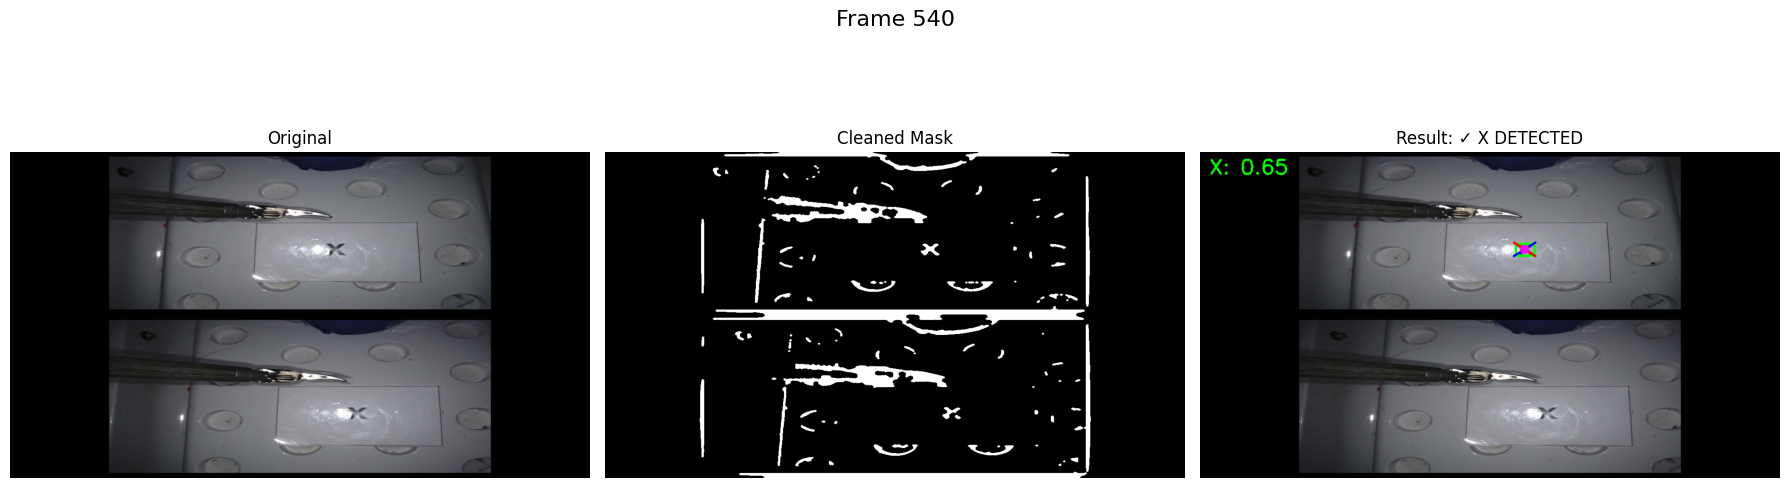

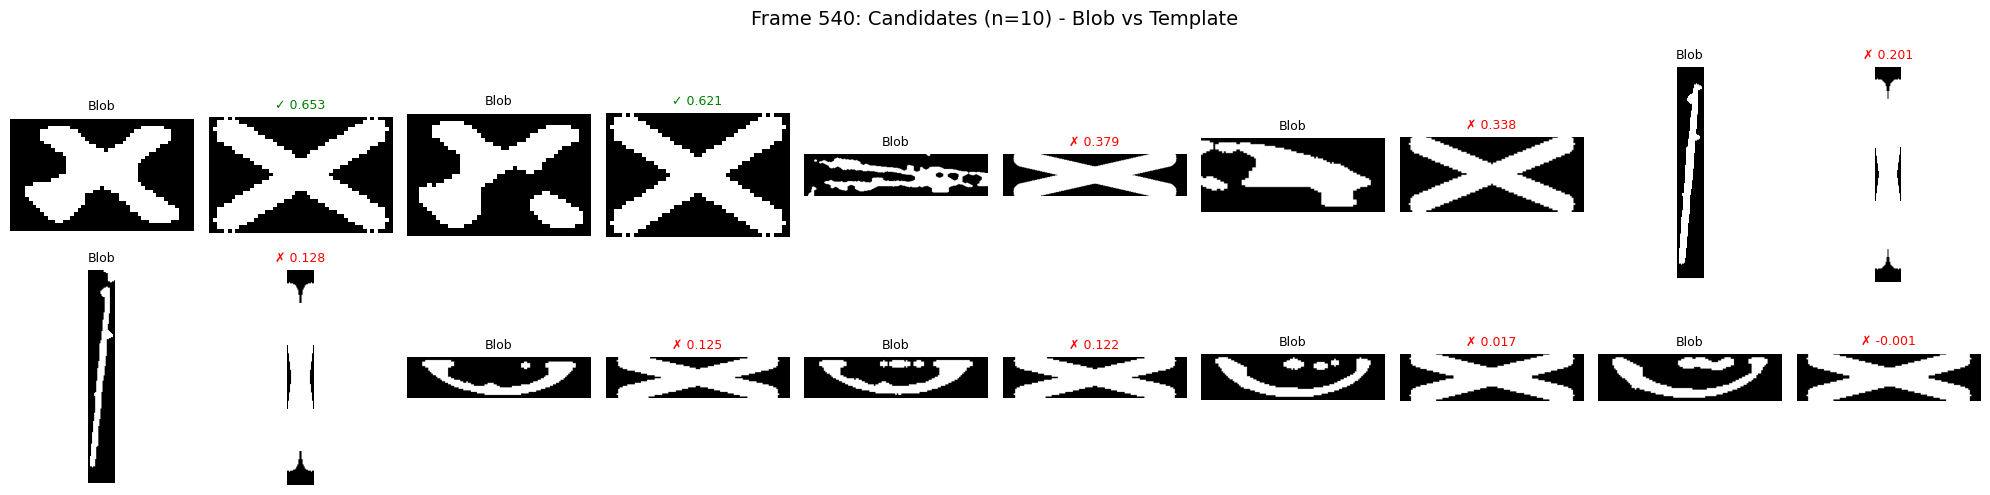


Frame 540:
  X Detected: True
  Match Score: 0.653 (threshold: 0.4)
  Template: 49x31px (thickness: 5px)
  Blob area: 574 pixels
  Total candidates: 10
  Score range: [-0.001, 0.653]



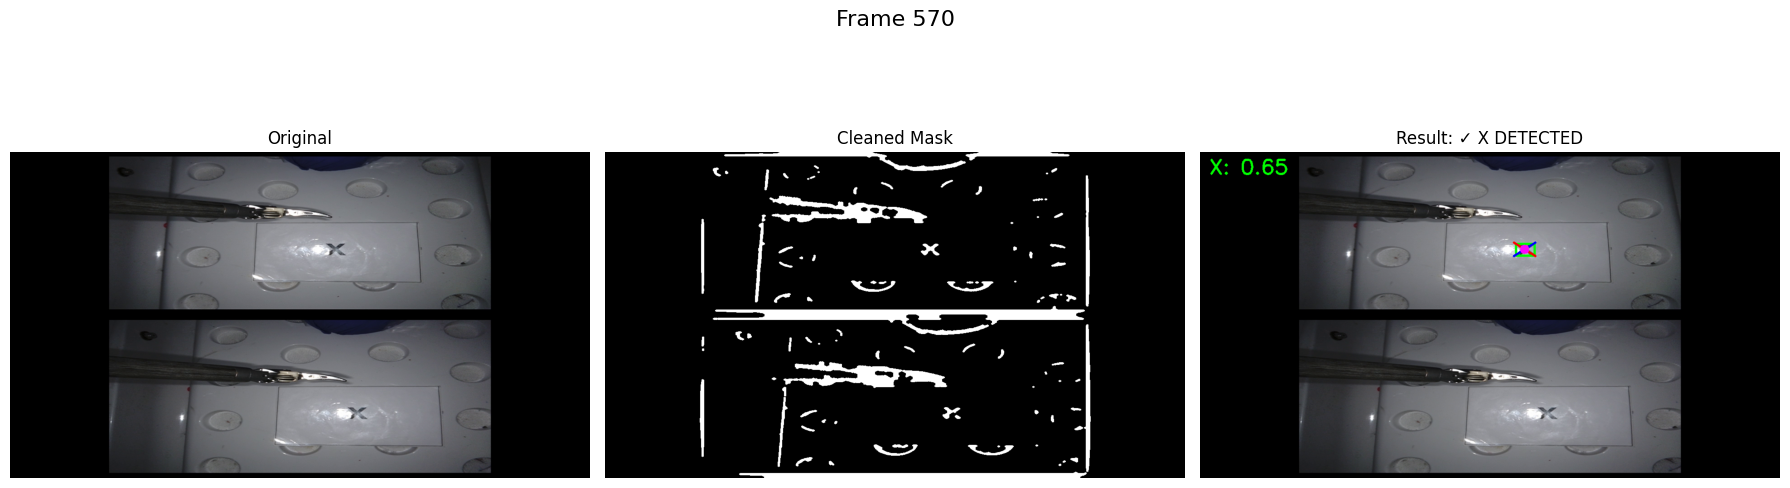

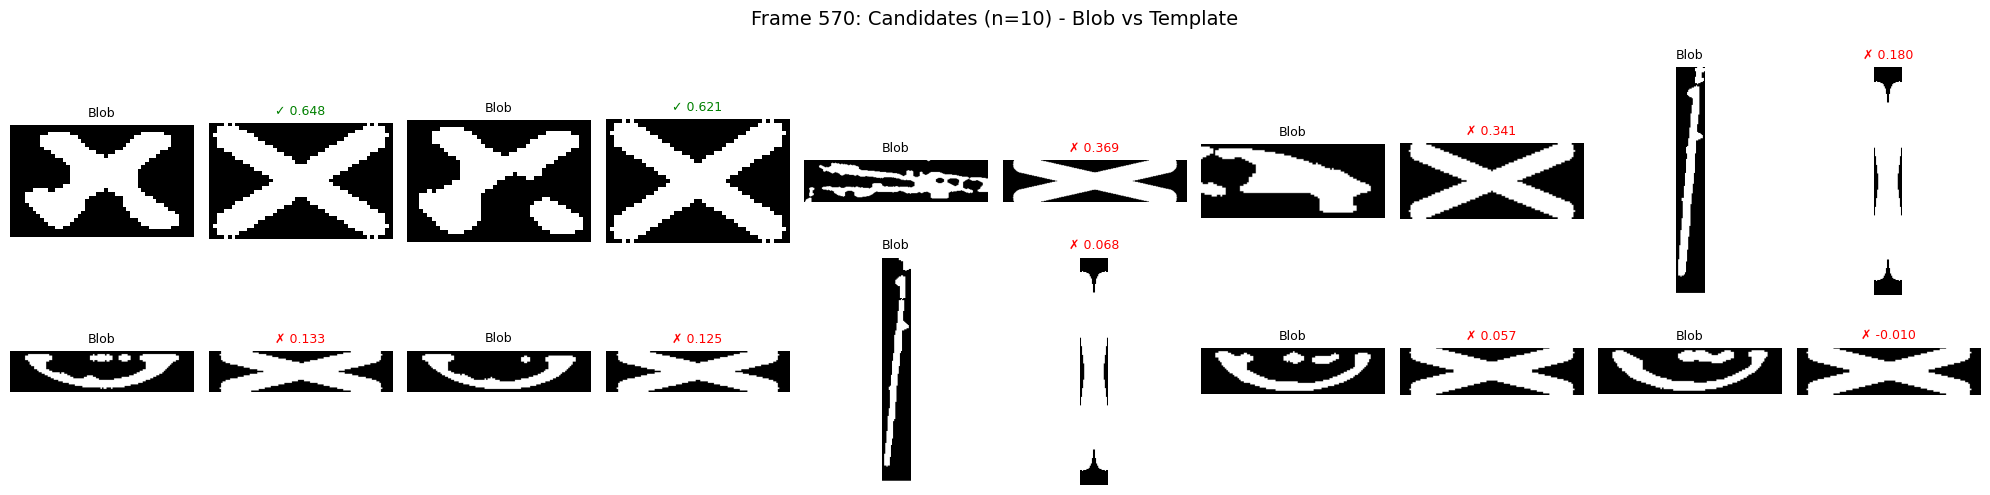


Frame 570:
  X Detected: True
  Match Score: 0.648 (threshold: 0.4)
  Template: 49x31px (thickness: 5px)
  Blob area: 551 pixels
  Total candidates: 10
  Score range: [-0.010, 0.648]


SUMMARY
Frames tested: 20
X detected: 19
Avg match score: 0.703


In [7]:
# Test on Selected Frames

results_summary = []

# Show pipeline flow once for first frame
if len(samples) > 0:
    first_idx, first_frame = samples[0]
    deglared_first, glare_mask_first = detect_and_remove_glare(first_frame)
    cleaned_mask_first = create_adaptive_mask(deglared_first)
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    axes[0].imshow(glare_mask_first, cmap='hot')
    glare_pct = np.sum(glare_mask_first) / (first_frame.shape[0] * first_frame.shape[1]) * 100
    axes[0].set_title(f'1. Glare Mask ({glare_pct:.1f}%)')
    axes[0].axis('off')
    
    axes[1].imshow(deglared_first, cmap='gray')
    axes[1].set_title('2. Deglared')
    axes[1].axis('off')
    
    axes[2].imshow(cleaned_mask_first, cmap='gray')
    mask_pct = np.sum(cleaned_mask_first > 0) / (first_frame.shape[0] * first_frame.shape[1]) * 100
    axes[2].set_title(f'3. Cleaned Mask ({mask_pct:.1f}%)')
    axes[2].axis('off')
    
    plt.suptitle('Pipeline Flow', fontsize=16, y=0.98)
    plt.tight_layout()
    plt.show()
    print("\n" + "="*60)
    print("PIPELINE FLOW (Frame 0)")
    print("="*60 + "\n")

# Process each frame
for frame_idx, frame in samples:
    # Run pipeline
    deglared, glare_mask = detect_and_remove_glare(frame)
    cleaned_mask = create_adaptive_mask(deglared)
    x_detected, confidence, details, candidates = detect_x(cleaned_mask, frame.shape)
    
    results_summary.append({
        'frame': frame_idx,
        'detected': x_detected,
        'score': confidence,
        'details': details
    })
    
    # Plot 1: Original, Cleaned Mask, Result
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    axes[0].imshow(frame)
    axes[0].set_title('Original')
    axes[0].axis('off')
    
    axes[1].imshow(cleaned_mask, cmap='gray')
    axes[1].set_title('Cleaned Mask')
    axes[1].axis('off')
    
    # Detection overlay
    result_overlay = frame.copy()
    
    if x_detected:
        bx, by, bw, bh = details['bbox']
        cv2.rectangle(result_overlay, (bx, by), (bx+bw, by+bh), (0, 255, 0), 3)
        
        cx, cy = details['centroid']
        tw, th = details['template_width'], details['template_height']
        half_w = tw // 2
        half_h = th // 2
        cv2.line(result_overlay, 
                 (int(cx - half_w), int(cy - half_h)), 
                 (int(cx + half_w), int(cy + half_h)), 
                 (255, 0, 0), 3)
        cv2.line(result_overlay, 
                 (int(cx - half_w), int(cy + half_h)), 
                 (int(cx + half_w), int(cy - half_h)), 
                 (0, 0, 255), 3)
        cv2.circle(result_overlay, (int(cx), int(cy)), 10, (255, 0, 255), -1)
        
        cv2.putText(result_overlay, f'X: {confidence:.2f}', (20, 50), 
                   cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 255, 0), 3)
    else:
        cv2.putText(result_overlay, 'NO X', (20, 50), 
                   cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 0, 0), 3)
    
    axes[2].imshow(result_overlay)
    axes[2].set_title(f'Result: {"✓ X DETECTED" if x_detected else "✗ NO X"}')
    axes[2].axis('off')
    
    plt.suptitle(f'Frame {frame_idx}', fontsize=16, y=0.98)
    plt.tight_layout()
    plt.show()
    
    # Plot 2: All Candidates with Templates
    if len(candidates) > 0:
        # Calculate grid size (2 columns per candidate: blob + template)
        num_candidates = len(candidates)
        cols = min(5, num_candidates) * 2  # 2 images per candidate
        rows = (num_candidates * 2 + cols - 1) // cols
        
        fig, axes = plt.subplots(rows, cols, figsize=(cols*2, rows*2.5))
        if rows == 1:
            axes = axes.reshape(1, -1)
        
        for idx, candidate in enumerate(candidates):
            col_start = (idx % (cols // 2)) * 2
            row = idx // (cols // 2)
            
            # Create template for this candidate (rectangular)
            template = create_x_template(candidate['template_width'], 
                                        candidate['template_height'], 
                                        candidate['line_thickness'])
            
            # Show blob
            axes[row, col_start].imshow(candidate['blob_image'], cmap='gray')
            axes[row, col_start].set_title('Blob', fontsize=9)
            axes[row, col_start].axis('off')
            
            # Show template (can be rectangular now)
            axes[row, col_start + 1].imshow(template, cmap='gray')
            score = candidate['match_score']
            color = 'green' if score >= MATCH_THRESHOLD else 'red'
            status = '✓' if score >= MATCH_THRESHOLD else '✗'
            axes[row, col_start + 1].set_title(f'{status} {score:.3f}', color=color, fontsize=9)
            axes[row, col_start + 1].axis('off')
        
        # Hide unused subplots
        total_used = num_candidates * 2
        for idx in range(total_used, rows * cols):
            row = idx // cols
            col = idx % cols
            axes[row, col].axis('off')
        
        plt.suptitle(f'Frame {frame_idx}: Candidates (n={num_candidates}) - Blob vs Template', fontsize=14, y=0.98)
        plt.tight_layout()
        plt.show()
    else:
        print(f"Frame {frame_idx}: No candidates found")
    
    # Print details
    print(f"\n{'='*60}")
    print(f"Frame {frame_idx}:")
    print(f"  X Detected: {x_detected}")
    print(f"  Match Score: {confidence:.3f} (threshold: {MATCH_THRESHOLD})")
    if x_detected:
        print(f"  Template: {details['template_width']}x{details['template_height']}px (thickness: {details['line_thickness']}px)")
        print(f"  Blob area: {details['area']} pixels")
    print(f"  Total candidates: {len(candidates)}")
    if len(candidates) > 0:
        scores = [c['match_score'] for c in candidates]
        print(f"  Score range: [{min(scores):.3f}, {max(scores):.3f}]")
    print(f"{'='*60}\n")

# Summary
print(f"\n{'='*60}")
print("SUMMARY")
print(f"{'='*60}")
print(f"Frames tested: {len(results_summary)}")
print(f"X detected: {sum(r['detected'] for r in results_summary)}")
if any(r['detected'] for r in results_summary):
    avg_score = np.mean([r['score'] for r in results_summary if r['detected']])
    print(f"Avg match score: {avg_score:.3f}")
print(f"{'='*60}")
